### Laboratory for Bank Loan Pricing _ 2024 - 2025
### Name: Tran Thuy Anh - 31738A
## Swap rate prediction based on real economic indicators

1. Data preparation
2. Exploratory data analysis
 - Statistics summary
 - Correlation matrix
 - Transformation
 - trends vs target
3. Linear model selection 
4. Final model and forecast target

In [422]:
#Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import scipy.stats as stats

#from sklearn.decomposition import PCA
from dateutil.relativedelta import relativedelta
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

### 1. Data preparation
#### 1.1 Predictors

In [514]:
# Load excel files
predictors = pd.read_excel(r'C:\Users\Admin\Downloads\BLP\blb ECO inidicatori significativi.xlsx',sheet_name ='data_value',
                           header=0)


In [515]:
# Extracting relevant data starting from column I, which corresponds to column index 8
# Column 8 has the period reference date, column 9 has the indicator value, column 10 has the release date
# The names of the indicators are in row 1 (index 0 for pandas)

# Extract columns starting from index 8 (i.e column I in the sheet)
data_columns = predictors.iloc[:, 8:]

# Calculate the number of full sets (period reference date, value, release date)
num_full_sets = (data_columns.shape[1]) // 3 # result=31 indicators

# Create a new dataframe for the desired output
new_dataframe_adjusted = pd.DataFrame()

# Iterate over the indicators and extract release date and data value
for idx in range(num_full_sets):
    try:
        # Calculate column indices for release date and data value
        release_date_col_idx = 3 * idx + 2  # Release date column relative to the sliced dataframe
        value_col_idx = 3 * idx + 1         # Data value column relative to the sliced dataframe
        name_col_idx = 3 * idx              # Name of the indicator column relative to the sliced dataframe

        # Extract the name of the indicator
        name = data_columns.iloc[0, name_col_idx]  # Indicator name from row 1

        # Skip if the name is NaN or empty
        if pd.isna(name) or name == '':
            continue

        # Extract release dates and values
        release_dates = data_columns.iloc[1:, release_date_col_idx]
        values = data_columns.iloc[1:, value_col_idx]

        # Convert release dates from format YYYYMMDD to datetime, then format to 'yyyy-MM-dd'
        release_dates = pd.to_datetime(release_dates, format='%Y%m%d', errors='coerce')
        release_dates = release_dates.apply(lambda x: x.strftime('%Y-%m-%d') if pd.notna(x) else np.nan)

        # Add to the dataframe in the correct order (release date first, then value)
        new_dataframe_adjusted[f'{name} - release date'] = release_dates.reset_index(drop=True)
        new_dataframe_adjusted[name] = values.reset_index(drop=True)
        
    except IndexError:
        # Break the loop if column indices go out of bounds
        break

# Reorder columns to have release date first for each indicator
column_order = []
for idx in range(num_full_sets):
    try:
        name_col_idx = 3 * idx
        name = data_columns.iloc[0, name_col_idx]
        if pd.notna(name) and name != '':
            column_order.append(f'{name} - release date')
            column_order.append(name)
    except IndexError:
        break

# Filter column_order to keep only columns that exist in new_dataframe_adjusted
existing_columns = new_dataframe_adjusted.columns
valid_column_order = [col for col in column_order if col in existing_columns]

# Reassign the dataframe with the correct column order
new_dataframe_adjusted = new_dataframe_adjusted[valid_column_order]

# Remove the first two rows explicitly, excluding the header
new_dataframe_adjusted = new_dataframe_adjusted.iloc[2:].reset_index(drop=True)


# Display the new adjusted dataframe to the user
print("Adjusted Extracted Indicator Data:")

# Save the dataframe to a CSV file
new_dataframe_adjusted.to_csv(r'C:\Users\Admin\Downloads\BLP\extracted_indicator_data.csv', index=False)


Adjusted Extracted Indicator Data:


In [425]:
new_dataframe_adjusted

,GRIFPBUS Index - release date,GRIFPBUS Index,ITBCI Index - release date,ITBCI Index,MPMIFRMA Index - release date,MPMIFRMA Index,GRZEWI Index - release date,GRZEWI Index,GRZECURR Index - release date,GRZECURR Index,...,ETSLTOTL Index - release date,ETSLTOTL Index,ADP CHNG Index - release date,ADP CHNG Index,LEI CHNG Index - release date,LEI CHNG Index,EMPRGBCI Index - release date,EMPRGBCI Index,CHPMINDX Index - release date,CHPMINDX Index
0,2004-12-17,NaN,2004-12-28,102.7,2005-01-03,NaN,2004-12-07,14.4,2004-12-07,-64.2,...,NaN,6.89,NaN,43.5,2005-01-20,0.9,2004-12-15,21.6,2004-12-30,61.2
1,2005-01-26,92.2,2005-01-27,102.0,2005-02-01,NaN,2005-01-11,26.9,2005-01-11,-61.2,...,2005-02-25,7.10,NaN,106.4,2005-02-17,0.5,2005-01-18,15.6,2005-01-31,63.0
2,2005-02-23,91.9,2005-02-23,101.1,2005-03-01,NaN,2005-02-15,35.9,2005-02-15,-58.7,...,2005-03-23,6.88,NaN,145.7,2005-03-17,0.5,2005-02-15,17.1,2005-02-28,65.3
3,2005-03-23,90.1,2005-03-24,100.0,2005-04-01,NaN,2005-03-15,36.3,2005-03-15,-66.0,...,2005-04-25,6.96,NaN,190.9,2005-04-21,-0.4,2005-03-15,24.3,2005-03-31,65.3
4,2005-04-25,90.0,2005-04-28,97.1,2005-05-02,NaN,2005-04-19,20.1,2005-04-19,-73.0,...,2005-05-24,7.12,NaN,219.6,2005-05-19,0.6,2005-04-15,8.3,2005-04-29,65.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,2021-06-24,101.9,2021-07-28,115.0,2021-07-01,59.0,2021-06-08,79.8,2021-06-08,-9.1,...,2021-07-22,5.87,2021-06-30,741.4,2021-07-22,0.6,2021-06-15,17.4,2021-06-30,66.1
199,2021-07-26,100.8,2021-08-27,113.2,2021-08-02,58.0,2021-07-06,63.3,2021-07-06,21.9,...,2021-08-23,6.00,2021-08-04,321.5,2021-08-19,0.8,2021-07-15,43.0,2021-07-30,73.4
200,2021-08-25,99.6,2021-09-24,113.0,2021-09-01,57.5,2021-08-10,40.4,2021-08-10,29.3,...,2021-09-22,5.88,2021-09-01,339.7,2021-09-23,0.9,2021-08-16,18.3,2021-08-31,66.8
201,2021-09-24,98.8,NaN,NaN,2021-10-01,55.0,2021-09-07,26.5,2021-09-07,31.9,...,2021-10-21,NaN,2021-10-06,568.1,2021-10-21,NaN,2021-09-15,34.3,2021-09-30,64.7


#### 1.2. Target - Y

In [426]:
swap_df = pd.read_excel(r'C:\Users\Admin\Downloads\BLP\swap_data.xlsx',sheet_name='df',header=0)
swap_df

,Date,USDSB3L10Y,USDSB3L5Y,USDSB3L2Y
0,2024-01-09,3.6020,3.5379,3.7170
1,2024-01-08,3.7210,3.6890,4.0092
2,2024-01-07,3.9424,3.9801,4.4429
3,2024-01-06,4.1525,4.2959,4.8460
4,2024-01-05,4.4600,4.6050,5.0990
...,...,...,...,...
166,2010-01-11,2.9660,1.7540,0.7560
167,2010-01-10,2.6800,1.4180,0.4940
168,2010-01-09,2.5610,1.4980,0.5950
169,2010-01-08,2.4810,1.6030,0.6490


In [427]:
swap_df['Date'] = pd.to_datetime(swap_df['Date'], format='%Y-%m-%d', errors='coerce')

# Extract only the Year and Month as a separate column
swap_df['Year-Month'] = swap_df['Date'].dt.strftime('%Y-%d')

# Set the 'Year-Month' column as the index and drop the original column
swap_df.set_index('Year-Month', inplace=True)

# Sort the dataframe by Date in ascending order
swap_df = swap_df.sort_values(by='Date')

# Calculate the spread: S(t) = USDSB3L10Y - USDSB3L2Y
swap_df['S(t)'] = swap_df['USDSB3L10Y'] - swap_df['USDSB3L2Y']

# Calculate the 6-month differential: y_6m_diff = S(t) - S(t-6)
swap_df['y_6m_diff'] = swap_df['S(t)'].diff(periods=6)

# Drop rows with NaN in 'Date' or NaN in 'y_6m_diff'
swap_df = swap_df.dropna(subset=['Date', 'y_6m_diff'])

# Only keep the column y_6m_diff (Year-Month is the index)
swap_df = swap_df[['y_6m_diff']]

swap_df.to_csv(r'C:\Users\Admin\Downloads\BLP\swap_df.csv')
swap_df

,y_6m_diff
Year-Month,
2011-01,0.5237
2011-02,0.8290
2011-03,0.6000
2011-04,0.4020
2011-05,0.2940
...,...
2024-05,-0.1010
2024-06,-0.0515
2024-07,-0.0218


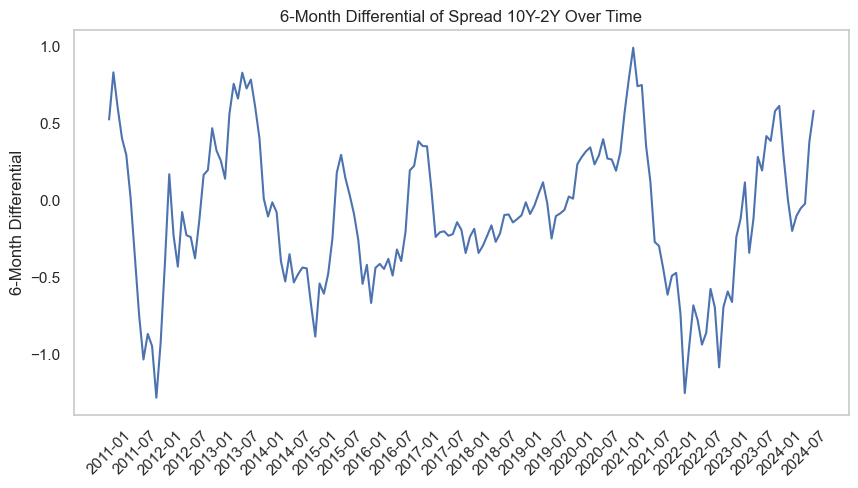

In [428]:
# Plot the transformed target y_6m_diff over time using the Date column
plt.figure(figsize=(10, 5))
plt.plot(swap_df.index, swap_df['y_6m_diff'], label='6-Month Differential (y_6m_diff)', color='b')
plt.ylabel('6-Month Differential')
plt.title('6-Month Differential of Spread 10Y-2Y Over Time')
plt.grid(False)
plt.xticks(ticks=range(0, len(swap_df.index), 6), rotation=45)

plt.show()

In [429]:
print(f"start date: {min(swap_df.index)}")
print(f"end date: {max(swap_df.index)}")

start date: 2011-01
end date: 2024-09


### 2. Exploratory  Data Analysis

In [516]:
# Statistic summary for each indicator, including missing values
summary_list = []
for idx in range(num_full_sets):
    try:
        name_col_idx = 3 * idx
        name = data_columns.iloc[0, name_col_idx]
        if pd.isna(name) or name == '':
            continue

        value_column = new_dataframe_adjusted[name]
        release_date_column = new_dataframe_adjusted[f'{name} - release date']

        # Convert release dates to datetime
        release_date_column = pd.to_datetime(release_date_column, errors='coerce')

        # Calculate statistics
        start_date = release_date_column.min()
        end_date = release_date_column.max()
        avg_value = value_column.mean()
        variance_values = value_column.var() * 100
        num_missing_values = value_column.isna().sum()
        total_values = len(value_column)
        missing_value_percentage = (num_missing_values / total_values) * 100
        num_missing_dates = release_date_column.isna().sum()
        total_dates = len(release_date_column)
        missing_date_percentage = (num_missing_dates / total_dates) * 100

        # Append to summary list
        summary_list.append({
            'Indicator': name,
            'Start Date': start_date.strftime('%Y-%m-%d') if pd.notna(start_date) else np.nan,
            'End Date': end_date.strftime('%Y-%m-%d') if pd.notna(end_date) else np.nan,
            'Average Value': avg_value,
            'Variance': variance_values,
            'Missing Value Percentage': missing_value_percentage,
            'Missing Date Percentage': missing_date_percentage
        })
    except IndexError:
        break

# Create a summary dataframe
summary_df = pd.DataFrame(summary_list)

# Display the summary dataframe
print("Statistical Summary for Each Indicator:")
summary_df.to_csv(r'C:\Users\Admin\Downloads\BLP\summary_df.csv')
summary_df


Statistical Summary for Each Indicator:


,Indicator,Start Date,End Date,Average Value,Variance,Missing Value Percentage,Missing Date Percentage
0,GRIFPBUS Index,2004-12-17,2021-09-24,97.057711,3.063265e+03,0.985222,0.492611
1,ITBCI Index,2004-12-28,2021-09-24,100.358706,7.575364e+03,0.985222,0.985222
2,MPMIFRMA Index,2005-01-03,2021-10-01,51.361111,2.748130e+03,82.266010,0.492611
3,GRZEWI Index,2004-12-07,2021-10-12,14.035468,1.113799e+05,0.000000,0.000000
4,GRZECURR Index,2004-12-07,2021-10-12,18.067980,3.054423e+05,0.000000,0.000000
5,GRIORTMM Index,2005-02-18,2021-12-06,0.251741,1.696331e+03,0.985222,0.000000
6,MPMIITMA Index,2005-01-03,2021-11-01,51.102778,4.134142e+03,82.266010,0.492611
7,MPMIDEMA Index,2005-01-03,2021-10-01,51.244444,7.807568e+03,82.266010,0.492611
8,MPMIEZMA Index,2005-01-03,2021-10-01,51.505556,4.775025e+03,82.266010,0.492611
9,MPMIESMA Index,2014-04-01,2021-11-01,50.786111,3.237780e+03,82.266010,54.679803


In [517]:
# Filter the indicators with less than 60% missing values
valid_indicators = summary_df[(summary_df['Missing Value Percentage'] < 5) & (summary_df['Missing Date Percentage'] < 5) ]['Indicator']

# Drop columns with missing percentage >= 60% from new_dataframe_adjusted
columns_to_keep = []
for indicator in valid_indicators:
    columns_to_keep.append(f'{indicator} - release date')
    columns_to_keep.append(indicator)

new_dataframe_adjusted_filtered = new_dataframe_adjusted[columns_to_keep]

# Display the filtered dataframe
print("Filtered DataFrame")
new_dataframe_adjusted_filtered

Filtered DataFrame


,GRIFPBUS Index - release date,GRIFPBUS Index,ITBCI Index - release date,ITBCI Index,GRZEWI Index - release date,GRZEWI Index,GRZECURR Index - release date,GRZECURR Index,GRIORTMM Index - release date,GRIORTMM Index,...,NHSPSTOT Index - release date,NHSPSTOT Index,ETSLTOTL Index - release date,ETSLTOTL Index,LEI CHNG Index - release date,LEI CHNG Index,EMPRGBCI Index - release date,EMPRGBCI Index,CHPMINDX Index - release date,CHPMINDX Index
0,2004-12-17,NaN,2004-12-28,102.7,2004-12-07,14.4,2004-12-07,-64.2,2005-02-18,6.4,...,2005-01-19,2042.0,NaN,6.89,2005-01-20,0.9,2004-12-15,21.6,2004-12-30,61.2
1,2005-01-26,92.2,2005-01-27,102.0,2005-01-11,26.9,2005-01-11,-61.2,2005-03-22,-2.6,...,2005-02-16,2144.0,2005-02-25,7.10,2005-02-17,0.5,2005-01-18,15.6,2005-01-31,63.0
2,2005-02-23,91.9,2005-02-23,101.1,2005-02-15,35.9,2005-02-15,-58.7,2005-04-21,-1.8,...,2005-03-16,2207.0,2005-03-23,6.88,2005-03-17,0.5,2005-02-15,17.1,2005-02-28,65.3
3,2005-03-23,90.1,2005-03-24,100.0,2005-03-15,36.3,2005-03-15,-66.0,2005-05-06,2.0,...,2005-04-19,1864.0,2005-04-25,6.96,2005-04-21,-0.4,2005-03-15,24.3,2005-03-31,65.3
4,2005-04-25,90.0,2005-04-28,97.1,2005-04-19,20.1,2005-04-19,-73.0,2005-06-06,-0.8,...,2005-05-17,2061.0,2005-05-24,7.12,2005-05-19,0.6,2005-04-15,8.3,2005-04-29,65.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,2021-06-24,101.9,2021-07-28,115.0,2021-06-08,79.8,2021-06-08,-9.1,2021-08-05,4.6,...,2021-07-20,1657.0,2021-07-22,5.87,2021-07-22,0.6,2021-06-15,17.4,2021-06-30,66.1
199,2021-07-26,100.8,2021-08-27,113.2,2021-07-06,63.3,2021-07-06,21.9,2021-09-06,4.9,...,2021-08-18,1554.0,2021-08-23,6.00,2021-08-19,0.8,2021-07-15,43.0,2021-07-30,73.4
200,2021-08-25,99.6,2021-09-24,113.0,2021-08-10,40.4,2021-08-10,29.3,2021-10-06,-7.7,...,2021-09-21,1615.0,2021-09-22,5.88,2021-09-23,0.9,2021-08-16,18.3,2021-08-31,66.8
201,2021-09-24,98.8,NaN,NaN,2021-09-07,26.5,2021-09-07,31.9,2021-11-04,NaN,...,2021-10-19,NaN,2021-10-21,NaN,2021-10-21,NaN,2021-09-15,34.3,2021-09-30,64.7


In [432]:
print(min(summary_df['Start Date']))
print(max(summary_df['End Date']))

2004-12-07
2021-12-06


In [518]:
# Loop through each column in the filtered dataframe
for column in new_dataframe_adjusted_filtered.columns:
    # If the column name contains 'release date', we modify it
    if 'release date' in column:
        # Convert the release date to datetime format, then extract only the year and month
        new_dataframe_adjusted_filtered[column] = pd.to_datetime(new_dataframe_adjusted_filtered[column], errors='coerce').dt.to_period('M').astype(str)

# Display the dataframe to verify the changes
print("DataFrame with Updated Release Date Columns:")
new_dataframe_adjusted_filtered.to_csv(r'C:\Users\Admin\Downloads\BLP\new_dataframe_adjusted_filtered.csv')
new_dataframe_adjusted_filtered

DataFrame with Updated Release Date Columns:


C:\Users\Admin\AppData\Local\Temp\ipykernel_18620\837938583.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_dataframe_adjusted_filtered[column] = pd.to_datetime(new_dataframe_adjusted_filtered[column], errors='coerce').dt.to_period('M').astype(str)
C:\Users\Admin\AppData\Local\Temp\ipykernel_18620\837938583.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_dataframe_adjusted_filtered[column] = pd.to_datetime(new_dataframe_adjusted_filtered[column], errors='coerce').dt.to_period('M').astype(str

,GRIFPBUS Index - release date,GRIFPBUS Index,ITBCI Index - release date,ITBCI Index,GRZEWI Index - release date,GRZEWI Index,GRZECURR Index - release date,GRZECURR Index,GRIORTMM Index - release date,GRIORTMM Index,...,NHSPSTOT Index - release date,NHSPSTOT Index,ETSLTOTL Index - release date,ETSLTOTL Index,LEI CHNG Index - release date,LEI CHNG Index,EMPRGBCI Index - release date,EMPRGBCI Index,CHPMINDX Index - release date,CHPMINDX Index
0,2004-12,NaN,2004-12,102.7,2004-12,14.4,2004-12,-64.2,2005-02,6.4,...,2005-01,2042.0,NaT,6.89,2005-01,0.9,2004-12,21.6,2004-12,61.2
1,2005-01,92.2,2005-01,102.0,2005-01,26.9,2005-01,-61.2,2005-03,-2.6,...,2005-02,2144.0,2005-02,7.10,2005-02,0.5,2005-01,15.6,2005-01,63.0
2,2005-02,91.9,2005-02,101.1,2005-02,35.9,2005-02,-58.7,2005-04,-1.8,...,2005-03,2207.0,2005-03,6.88,2005-03,0.5,2005-02,17.1,2005-02,65.3
3,2005-03,90.1,2005-03,100.0,2005-03,36.3,2005-03,-66.0,2005-05,2.0,...,2005-04,1864.0,2005-04,6.96,2005-04,-0.4,2005-03,24.3,2005-03,65.3
4,2005-04,90.0,2005-04,97.1,2005-04,20.1,2005-04,-73.0,2005-06,-0.8,...,2005-05,2061.0,2005-05,7.12,2005-05,0.6,2005-04,8.3,2005-04,65.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,2021-06,101.9,2021-07,115.0,2021-06,79.8,2021-06,-9.1,2021-08,4.6,...,2021-07,1657.0,2021-07,5.87,2021-07,0.6,2021-06,17.4,2021-06,66.1
199,2021-07,100.8,2021-08,113.2,2021-07,63.3,2021-07,21.9,2021-09,4.9,...,2021-08,1554.0,2021-08,6.00,2021-08,0.8,2021-07,43.0,2021-07,73.4
200,2021-08,99.6,2021-09,113.0,2021-08,40.4,2021-08,29.3,2021-10,-7.7,...,2021-09,1615.0,2021-09,5.88,2021-09,0.9,2021-08,18.3,2021-08,66.8
201,2021-09,98.8,NaT,NaN,2021-09,26.5,2021-09,31.9,2021-11,NaN,...,2021-10,NaN,2021-10,NaN,2021-10,NaN,2021-09,34.3,2021-09,64.7


In [519]:
# Loop through each column in the filtered dataframe to identify release date columns
for column in new_dataframe_adjusted_filtered.columns:
    if 'release date' in column:
        # Check for duplicates in the release date column
        duplicates = new_dataframe_adjusted_filtered[column].duplicated(keep=False)  # 'keep=False' marks all duplicate entries as True
        if duplicates.any():
            print(f"Duplicates found in column: {column}")
            print(new_dataframe_adjusted_filtered[column][duplicates].value_counts())  # Display duplicate dates and their counts


Duplicates found in column: ITBCI Index - release date
ITBCI Index - release date
2005-09    2
2008-09    2
2009-09    2
NaT        2
Name: count, dtype: int64
Duplicates found in column: ITPSSA Index - release date
ITPSSA Index - release date
2005-09    2
NaT        2
Name: count, dtype: int64
Duplicates found in column: SWRSAMM Index - release date
SWRSAMM Index - release date
2010-03    2
2015-06    2
2019-06    2
2020-01    2
Name: count, dtype: int64
Duplicates found in column: CONSSENT Index - release date
CONSSENT Index - release date
2005-04    2
2005-07    2
2020-10    2
2019-08    2
2019-03    2
2018-03    2
2017-09    2
2016-04    2
2015-05    2
2014-08    2
2013-03    2
2011-07    2
2010-10    2
2009-05    2
2008-02    2
2007-06    2
2007-03    2
2006-09    2
2006-03    2
2021-10    2
Name: count, dtype: int64
Duplicates found in column: CONCCONF Index - release date
CONCCONF Index - release date
2012-11    2
Name: count, dtype: int64
Duplicates found in column: RSTAMOM Ind

In [520]:
# FILL IN MISSING DATES
# Iterate over each "release date" column in the dataframe
for column in new_dataframe_adjusted_filtered.columns:
    if 'release date' in column:
        # Convert to datetime
        new_dataframe_adjusted_filtered[column] = pd.to_datetime(new_dataframe_adjusted_filtered[column], errors='coerce', format='%Y-%m')

        # Sort the values by release date to ensure we check them sequentially
        new_dataframe_adjusted_filtered = new_dataframe_adjusted_filtered.sort_values(by=column).reset_index(drop=True)

        # Iterate through the column, fixing duplicates as needed
        prev_date = None
        for i in range(len(new_dataframe_adjusted_filtered)):
            current_date = new_dataframe_adjusted_filtered.at[i, column]

            # If this is the first date, initialize prev_date
            if prev_date is None:
                prev_date = current_date
                continue

            # If current_date is the same as the previous one, we need to adjust it
            if current_date != prev_date + relativedelta(months=1):
               # Adjust the current date to be the previous date + 1 month
                new_date = prev_date + relativedelta(months=1)
                new_dataframe_adjusted_filtered.at[i, column] = new_date
                prev_date = new_date  # Update prev_date to the new fixed date
            else:
                # If current_date is not a duplicate, just update prev_date
                prev_date = current_date
        # After fixing duplicates, reformat the column to only include year and month
        new_dataframe_adjusted_filtered[column] = new_dataframe_adjusted_filtered[column].dt.to_period('M').astype(str)
# Display the fixed dataframe
print("DataFrame after fixing duplicate release dates:")
new_dataframe_adjusted_filtered

DataFrame after fixing duplicate release dates:


C:\Users\Admin\AppData\Local\Temp\ipykernel_18620\3820433348.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_dataframe_adjusted_filtered[column] = pd.to_datetime(new_dataframe_adjusted_filtered[column], errors='coerce', format='%Y-%m')


,GRIFPBUS Index - release date,GRIFPBUS Index,ITBCI Index - release date,ITBCI Index,GRZEWI Index - release date,GRZEWI Index,GRZECURR Index - release date,GRZECURR Index,GRIORTMM Index - release date,GRIORTMM Index,...,NHSPSTOT Index - release date,NHSPSTOT Index,ETSLTOTL Index - release date,ETSLTOTL Index,LEI CHNG Index - release date,LEI CHNG Index,EMPRGBCI Index - release date,EMPRGBCI Index,CHPMINDX Index - release date,CHPMINDX Index
0,2004-12,NaN,2004-12,102.7,2004-12,14.4,2004-12,-64.2,2005-02,6.4,...,2005-01,2042.0,2021-11,6.89,2005-01,0.9,2004-12,21.6,2004-12,61.2
1,2005-01,92.2,2005-01,102.0,2005-01,26.9,2005-01,-61.2,2005-03,-2.6,...,2005-02,2144.0,2005-02,7.10,2005-02,0.5,2005-01,15.6,2005-01,63.0
2,2005-02,91.9,2005-02,101.1,2005-02,35.9,2005-02,-58.7,2005-04,-1.8,...,2005-03,2207.0,2005-03,6.88,2005-03,0.5,2005-02,17.1,2005-02,65.3
3,2005-03,90.1,2005-03,100.0,2005-03,36.3,2005-03,-66.0,2005-05,2.0,...,2005-04,1864.0,2005-04,6.96,2005-04,-0.4,2005-03,24.3,2005-03,65.3
4,2005-04,90.0,2005-04,97.1,2005-04,20.1,2005-04,-73.0,2005-06,-0.8,...,2005-05,2061.0,2005-05,7.12,2005-05,0.6,2005-04,8.3,2005-04,65.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,2021-06,101.9,2021-06,115.0,2021-06,79.8,2021-06,-9.1,2021-08,4.6,...,2021-07,1657.0,2021-07,5.87,2021-07,0.6,2021-06,17.4,2021-06,66.1
199,2021-07,100.8,2021-07,113.2,2021-07,63.3,2021-07,21.9,2021-09,4.9,...,2021-08,1554.0,2021-08,6.00,2021-08,0.8,2021-07,43.0,2021-07,73.4
200,2021-08,99.6,2021-08,113.0,2021-08,40.4,2021-08,29.3,2021-10,-7.7,...,2021-09,1615.0,2021-09,5.88,2021-09,0.9,2021-08,18.3,2021-08,66.8
201,2021-09,98.8,2021-09,NaN,2021-09,26.5,2021-09,31.9,2021-11,NaN,...,2021-10,NaN,2021-10,NaN,2021-10,NaN,2021-09,34.3,2021-09,64.7


In [521]:
# Loop through each column in the filtered dataframe to identify release date columns
for column in new_dataframe_adjusted_filtered.columns:
    if 'release date' in column:
        # Check for duplicates in the release date column
        duplicates = new_dataframe_adjusted_filtered[column].duplicated(keep=False)  # 'keep=False' marks all duplicate entries as True
        if duplicates.any():
            print(f"Duplicates found in column: {column}")
            print(new_dataframe_adjusted_filtered[column][duplicates].value_counts())  # Display duplicate dates and their counts
        else:
            print("No duplicates found")


No duplicates found
No duplicates found
No duplicates found
No duplicates found
No duplicates found
No duplicates found
No duplicates found
No duplicates found
No duplicates found
No duplicates found
No duplicates found
No duplicates found
No duplicates found
No duplicates found
No duplicates found
No duplicates found
No duplicates found
No duplicates found
No duplicates found
No duplicates found


In [522]:
# CHECK MISSING VALUES
# Calculate the total number of missing values for each column
missing_values_count = new_dataframe_adjusted_filtered.isna().sum()
missing_summary_df = pd.DataFrame({
    'Missing Values Count': missing_values_count
})

# Display the missing values summary dataframe
print("Missing Values Summary for Each Column in new_dataframe_adjusted_filtered:")
missing_summary_df

Missing Values Summary for Each Column in new_dataframe_adjusted_filtered:


,Missing Values Count
GRIFPBUS Index - release date,0
GRIFPBUS Index,2
ITBCI Index - release date,0
ITBCI Index,2
GRZEWI Index - release date,0
GRZEWI Index,0
GRZECURR Index - release date,0
GRZECURR Index,0
GRIORTMM Index - release date,0
GRIORTMM Index,2


In [523]:
#SORT RELEASE DATES
# Loop through each "release date" column in the filtered dataframe and sort
for idx in range(0, len(new_dataframe_adjusted_filtered.columns), 2):
    release_date_col = new_dataframe_adjusted_filtered.columns[idx]
    value_col = new_dataframe_adjusted_filtered.columns[idx + 1]

    # Sort by release date
    sorted_df = new_dataframe_adjusted_filtered[[release_date_col, value_col]].sort_values(by=release_date_col).reset_index(drop=True)

    # Replace the original columns with the sorted values
    new_dataframe_adjusted_filtered[release_date_col] = sorted_df[release_date_col]
    new_dataframe_adjusted_filtered[value_col] = sorted_df[value_col]

# Display the dataframe to verify the changes
print("DataFrame with Sorted Release Date Columns:")
new_dataframe_adjusted_filtered

DataFrame with Sorted Release Date Columns:


,GRIFPBUS Index - release date,GRIFPBUS Index,ITBCI Index - release date,ITBCI Index,GRZEWI Index - release date,GRZEWI Index,GRZECURR Index - release date,GRZECURR Index,GRIORTMM Index - release date,GRIORTMM Index,...,NHSPSTOT Index - release date,NHSPSTOT Index,ETSLTOTL Index - release date,ETSLTOTL Index,LEI CHNG Index - release date,LEI CHNG Index,EMPRGBCI Index - release date,EMPRGBCI Index,CHPMINDX Index - release date,CHPMINDX Index
0,2004-12,NaN,2004-12,102.7,2004-12,14.4,2004-12,-64.2,2005-02,6.4,...,2005-01,2042.0,2005-02,7.10,2005-01,0.9,2004-12,21.6,2004-12,61.2
1,2005-01,92.2,2005-01,102.0,2005-01,26.9,2005-01,-61.2,2005-03,-2.6,...,2005-02,2144.0,2005-03,6.88,2005-02,0.5,2005-01,15.6,2005-01,63.0
2,2005-02,91.9,2005-02,101.1,2005-02,35.9,2005-02,-58.7,2005-04,-1.8,...,2005-03,2207.0,2005-04,6.96,2005-03,0.5,2005-02,17.1,2005-02,65.3
3,2005-03,90.1,2005-03,100.0,2005-03,36.3,2005-03,-66.0,2005-05,2.0,...,2005-04,1864.0,2005-05,7.12,2005-04,-0.4,2005-03,24.3,2005-03,65.3
4,2005-04,90.0,2005-04,97.1,2005-04,20.1,2005-04,-73.0,2005-06,-0.8,...,2005-05,2061.0,2005-06,7.08,2005-05,0.6,2005-04,8.3,2005-04,65.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,2021-06,101.9,2021-06,115.0,2021-06,79.8,2021-06,-9.1,2021-08,4.6,...,2021-07,1657.0,2021-08,6.00,2021-07,0.6,2021-06,17.4,2021-06,66.1
199,2021-07,100.8,2021-07,113.2,2021-07,63.3,2021-07,21.9,2021-09,4.9,...,2021-08,1554.0,2021-09,5.88,2021-08,0.8,2021-07,43.0,2021-07,73.4
200,2021-08,99.6,2021-08,113.0,2021-08,40.4,2021-08,29.3,2021-10,-7.7,...,2021-09,1615.0,2021-10,NaN,2021-09,0.9,2021-08,18.3,2021-08,66.8
201,2021-09,98.8,2021-09,NaN,2021-09,26.5,2021-09,31.9,2021-11,NaN,...,2021-10,NaN,2021-11,6.89,2021-10,NaN,2021-09,34.3,2021-09,64.7


In [524]:
# FILL NA VALUES
# Iterate over each pair of "release date" and value columns in the dataframe
for idx in range(0, len(new_dataframe_adjusted_filtered.columns), 2):
    release_date_col = new_dataframe_adjusted_filtered.columns[idx]
    value_col = new_dataframe_adjusted_filtered.columns[idx + 1]

    # Ensure the data is sorted by release date
    new_dataframe_adjusted_filtered = new_dataframe_adjusted_filtered.sort_values(by=release_date_col).reset_index(drop=True)

    # Fill NA values in the value column
    for i in range(len(new_dataframe_adjusted_filtered)):
        # If the value is NA and it's the first value, set it equal to the next non-null value
        if pd.isna(new_dataframe_adjusted_filtered.at[i, value_col]):
            if i == 0:
                next_valid_idx = new_dataframe_adjusted_filtered[value_col].first_valid_index()
                if next_valid_idx is not None:
                    new_dataframe_adjusted_filtered.at[i, value_col] = new_dataframe_adjusted_filtered.at[next_valid_idx, value_col]
            else:
                # If it's not the first value, set it equal to the previous non-null value
                new_dataframe_adjusted_filtered.at[i, value_col] = new_dataframe_adjusted_filtered.at[i - 1, value_col]

# Display the dataframe to verify the changes
print("DataFrame after filling NA values:")
new_dataframe_adjusted_filtered

# Save to a CSV file to verify in detail if needed
#new_dataframe_adjusted_filtered.to_csv(r'C:\Users\Admin\Downloads\BLP\new_dataframe_adjusted_filtered_filled.csv', index=False)


DataFrame after filling NA values:


,GRIFPBUS Index - release date,GRIFPBUS Index,ITBCI Index - release date,ITBCI Index,GRZEWI Index - release date,GRZEWI Index,GRZECURR Index - release date,GRZECURR Index,GRIORTMM Index - release date,GRIORTMM Index,...,NHSPSTOT Index - release date,NHSPSTOT Index,ETSLTOTL Index - release date,ETSLTOTL Index,LEI CHNG Index - release date,LEI CHNG Index,EMPRGBCI Index - release date,EMPRGBCI Index,CHPMINDX Index - release date,CHPMINDX Index
0,2004-12,92.2,2004-12,102.7,2004-12,14.4,2004-12,-64.2,2005-02,6.4,...,2005-01,2042.0,2005-02,7.10,2005-01,0.9,2004-12,21.6,2004-12,61.2
1,2005-01,92.2,2005-01,102.0,2005-01,26.9,2005-01,-61.2,2005-03,-2.6,...,2005-02,2144.0,2005-03,6.88,2005-02,0.5,2005-01,15.6,2005-01,63.0
2,2005-02,91.9,2005-02,101.1,2005-02,35.9,2005-02,-58.7,2005-04,-1.8,...,2005-03,2207.0,2005-04,6.96,2005-03,0.5,2005-02,17.1,2005-02,65.3
3,2005-03,90.1,2005-03,100.0,2005-03,36.3,2005-03,-66.0,2005-05,2.0,...,2005-04,1864.0,2005-05,7.12,2005-04,-0.4,2005-03,24.3,2005-03,65.3
4,2005-04,90.0,2005-04,97.1,2005-04,20.1,2005-04,-73.0,2005-06,-0.8,...,2005-05,2061.0,2005-06,7.08,2005-05,0.6,2005-04,8.3,2005-04,65.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,2021-06,101.9,2021-06,115.0,2021-06,79.8,2021-06,-9.1,2021-08,4.6,...,2021-07,1657.0,2021-08,6.00,2021-07,0.6,2021-06,17.4,2021-06,66.1
199,2021-07,100.8,2021-07,113.2,2021-07,63.3,2021-07,21.9,2021-09,4.9,...,2021-08,1554.0,2021-09,5.88,2021-08,0.8,2021-07,43.0,2021-07,73.4
200,2021-08,99.6,2021-08,113.0,2021-08,40.4,2021-08,29.3,2021-10,-7.7,...,2021-09,1615.0,2021-10,5.88,2021-09,0.9,2021-08,18.3,2021-08,66.8
201,2021-09,98.8,2021-09,113.0,2021-09,26.5,2021-09,31.9,2021-11,-7.7,...,2021-10,1615.0,2021-11,6.89,2021-10,0.9,2021-09,34.3,2021-09,64.7


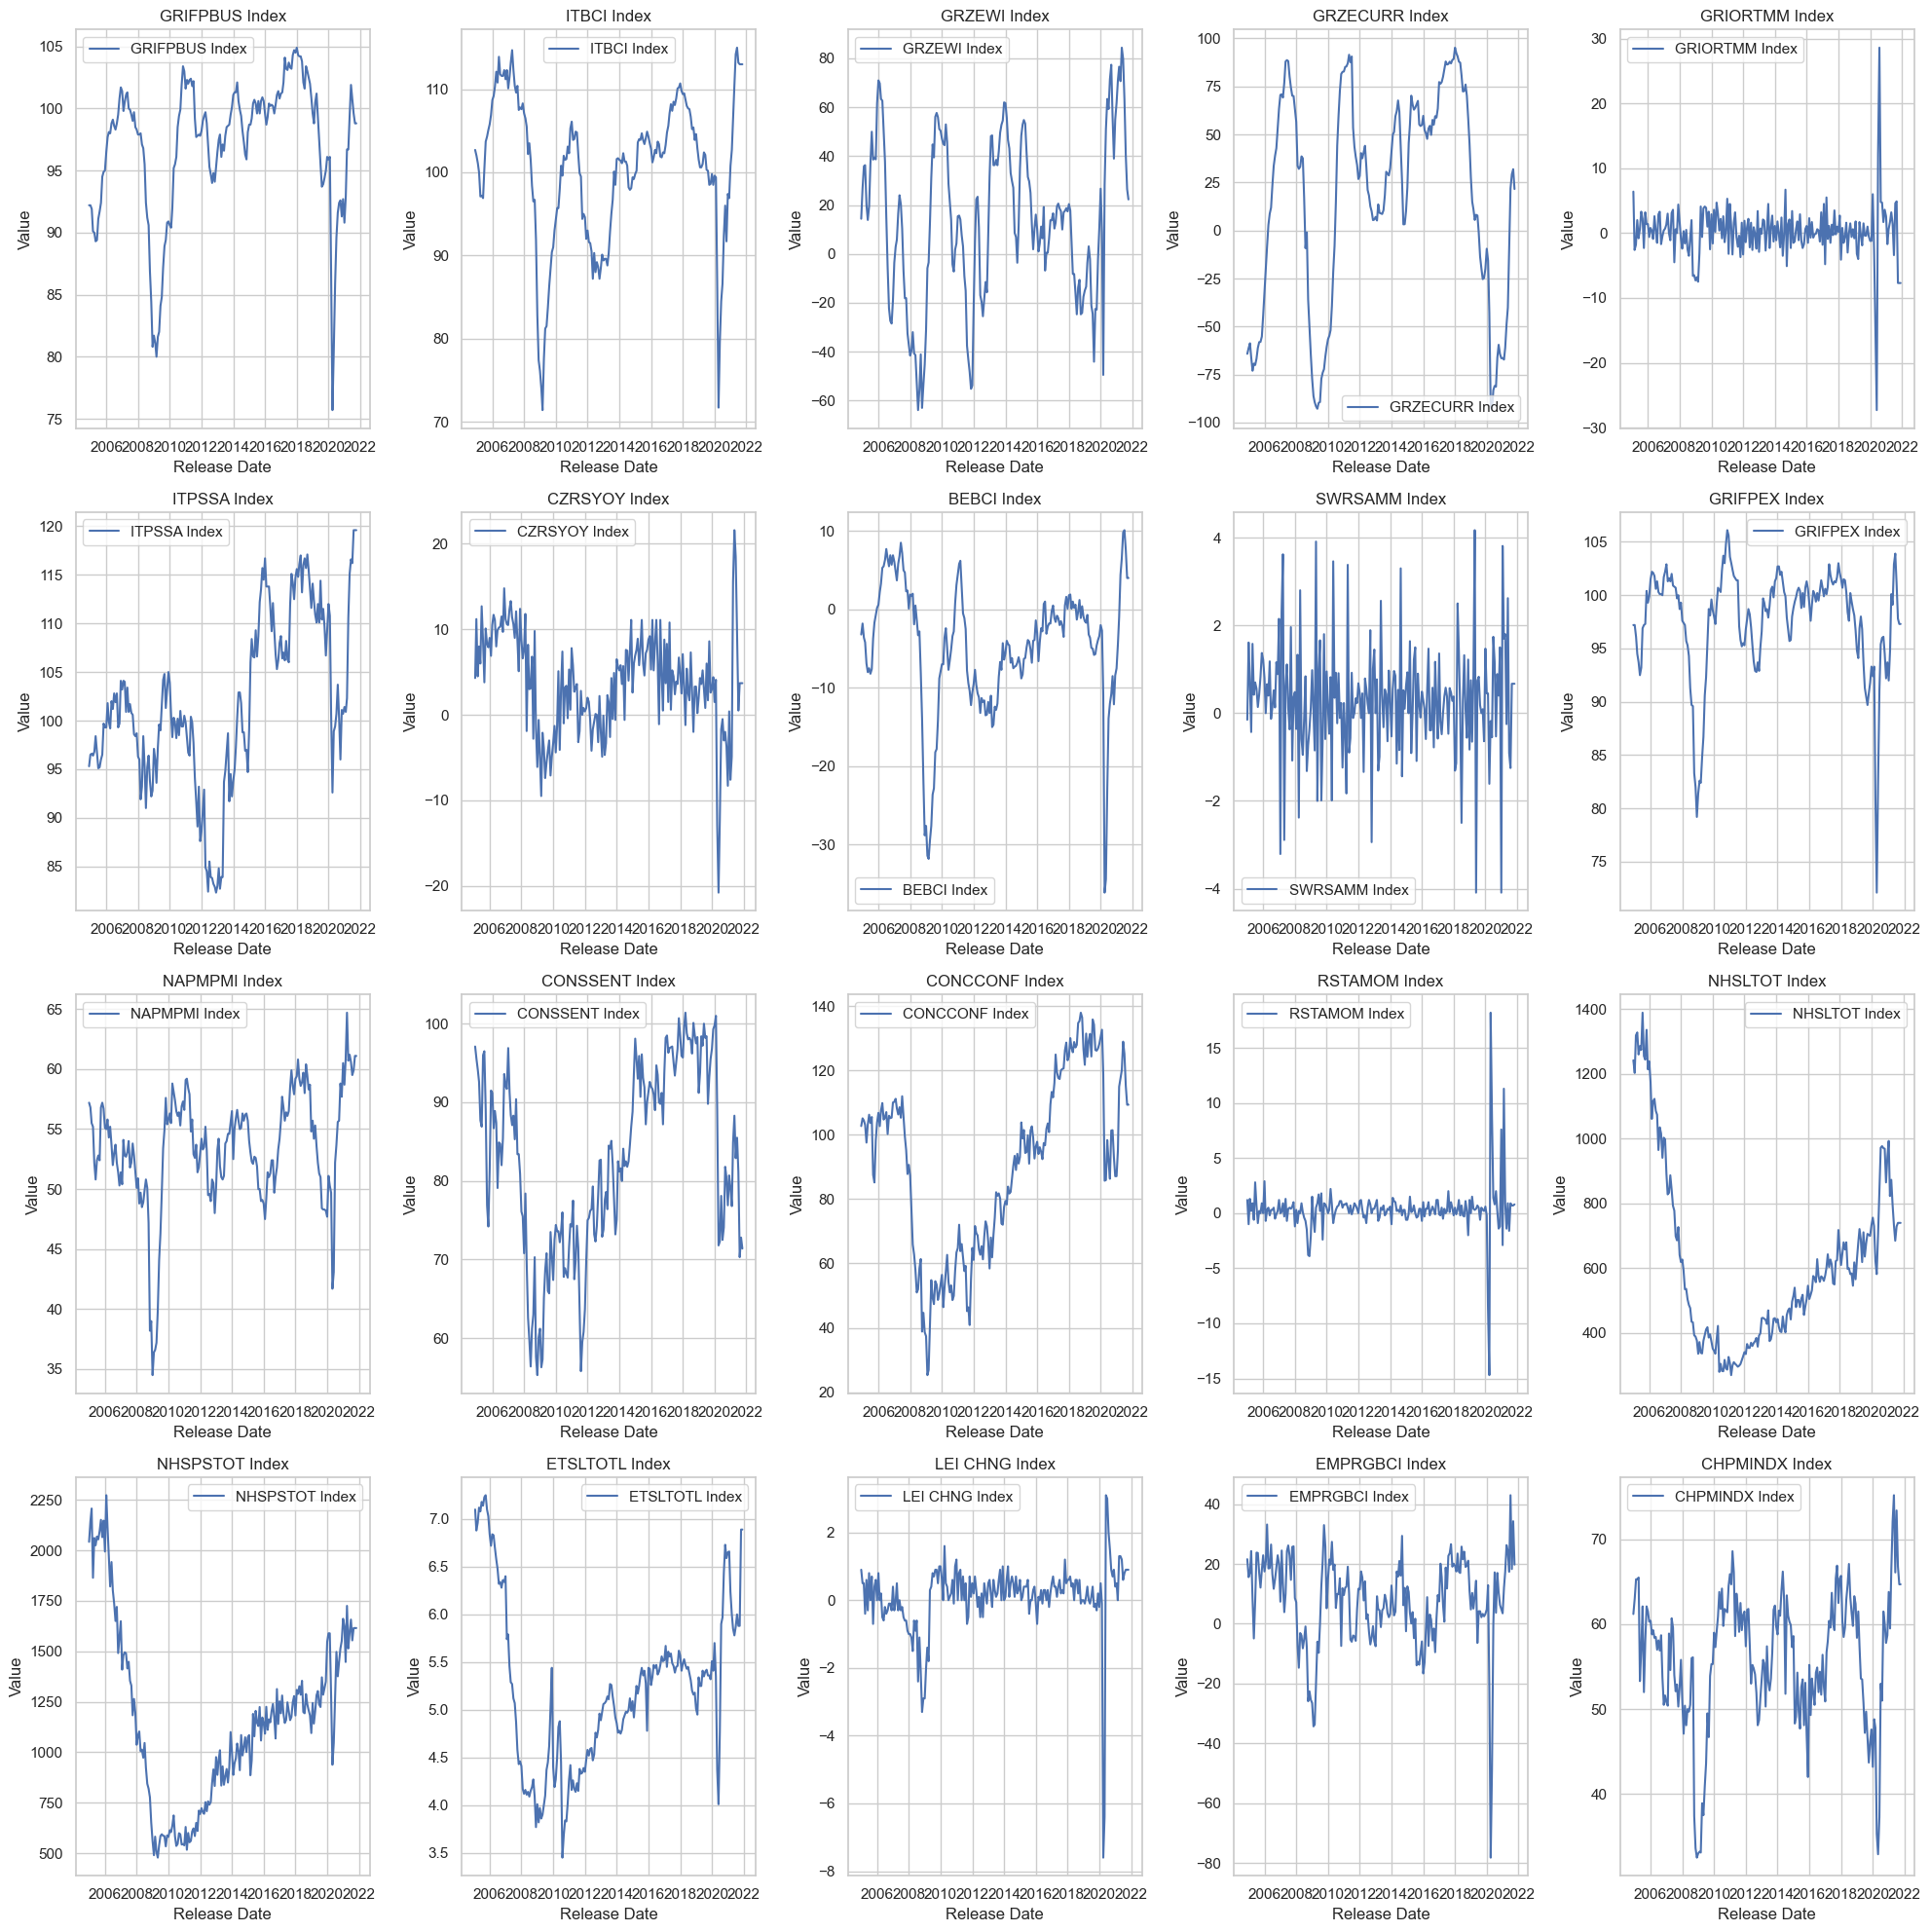

In [525]:
# Now plot the features 
value_columns = [col for col in new_dataframe_adjusted_filtered.columns if 'release date' not in col]

# Determine the number of plots required
num_features = len(value_columns)
num_plots_per_row = 5
num_rows = (num_features + num_plots_per_row - 1) // num_plots_per_row

# Create subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_plots_per_row, figsize=(20, num_rows * 5))
axes = axes.flatten()

# Iterate over the value columns to plot
for idx, column in enumerate(value_columns):
    ax = axes[idx]

    # Extract the corresponding release date column
    release_date_column = f'{column} - release date'
    release_dates = pd.to_datetime(new_dataframe_adjusted_filtered[release_date_column], errors='coerce')
    values = new_dataframe_adjusted_filtered[column]

    # Plot the data
    ax.plot(release_dates, values, label=column, color='b')
    ax.set_xlabel('Release Date')
    ax.set_ylabel('Value')
    ax.set_title(f'{column}')
    ax.legend()
    ax.grid(True)

# Hide any unused subplots
for idx in range(num_features, len(axes)):
    axes[idx].set_visible(False)

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

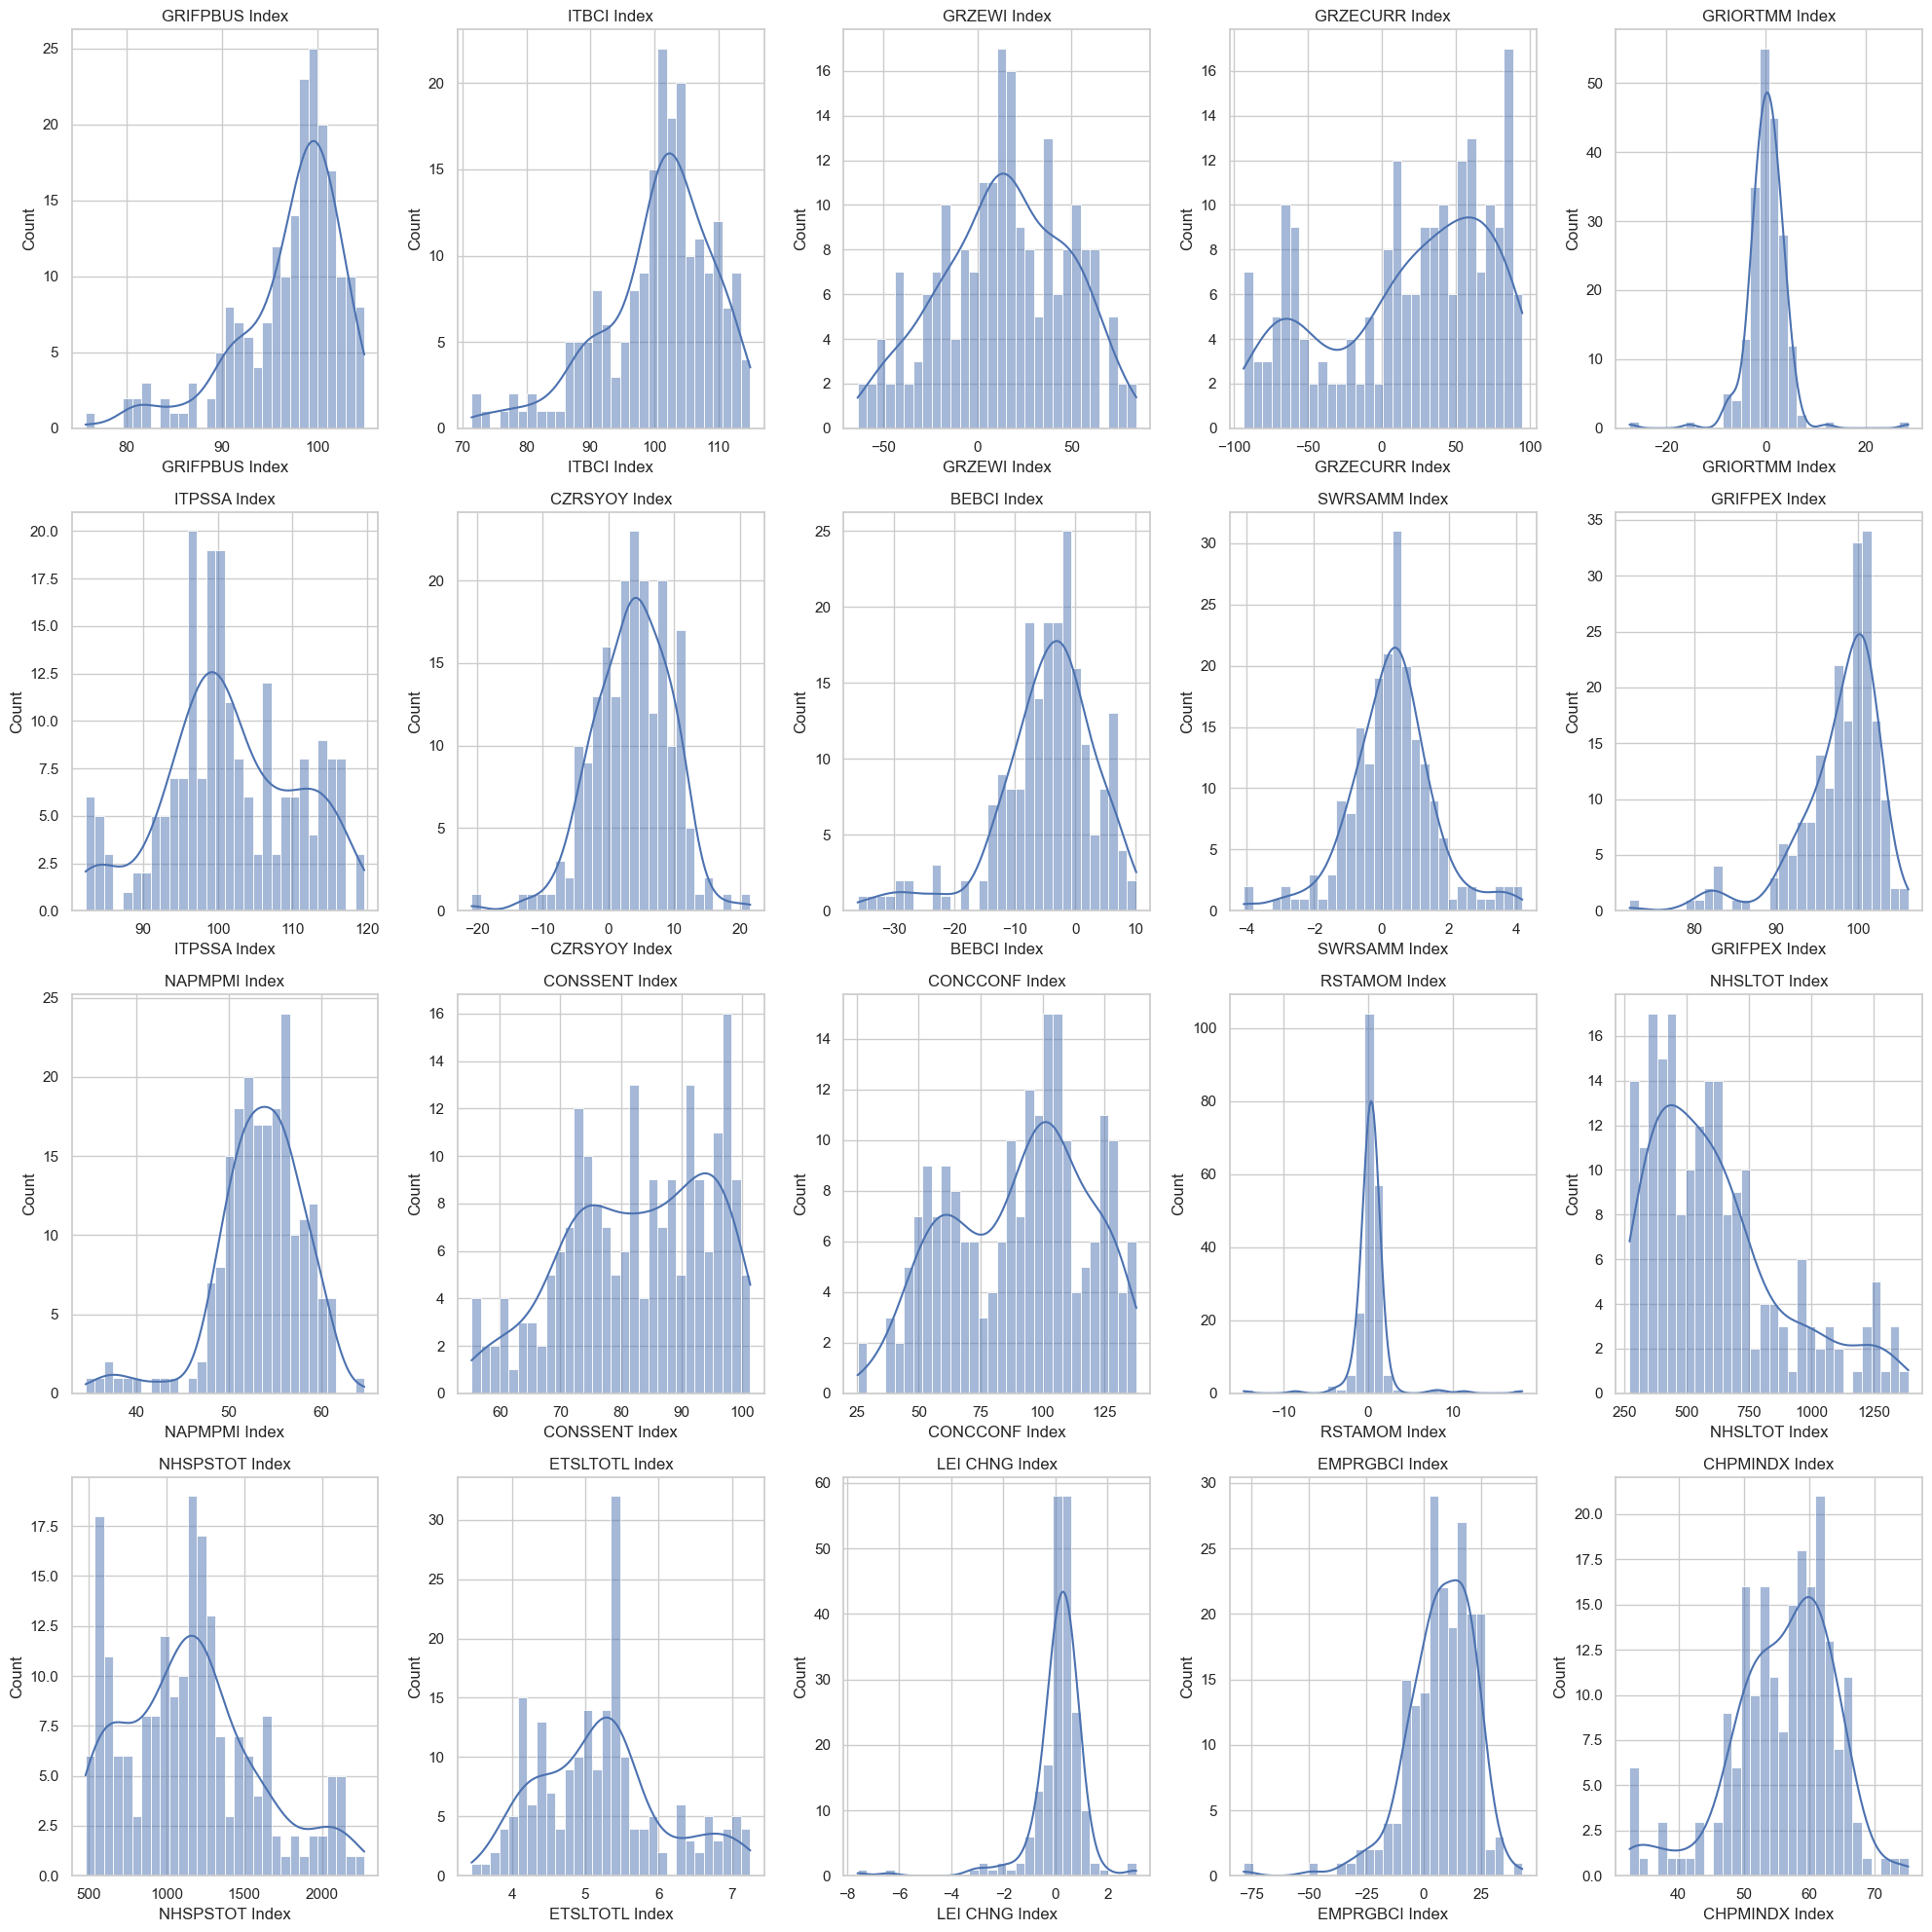

In [526]:
# Assuming value columns do not contain 'release date'
value_columns = [col for col in new_dataframe_adjusted_filtered.columns if 'release date' not in col]
features_values = new_dataframe_adjusted_filtered[value_columns]

# Set up the plotting
num_features = len(features_values.columns)
num_plots_per_row = 5
num_rows = (num_features + num_plots_per_row - 1) // num_plots_per_row

# Create the figure for subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_plots_per_row, figsize=(20, num_rows * 5))
axes = axes.flatten()

# Loop through each feature and plot its distribution
for idx, feature in enumerate(value_columns):
    ax = axes[idx]
    sns.histplot(features_values[feature], kde=True, ax=ax, color='b', bins=30)
    ax.set_title(feature)

# Hide any remaining empty subplots
for idx in range(num_features, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

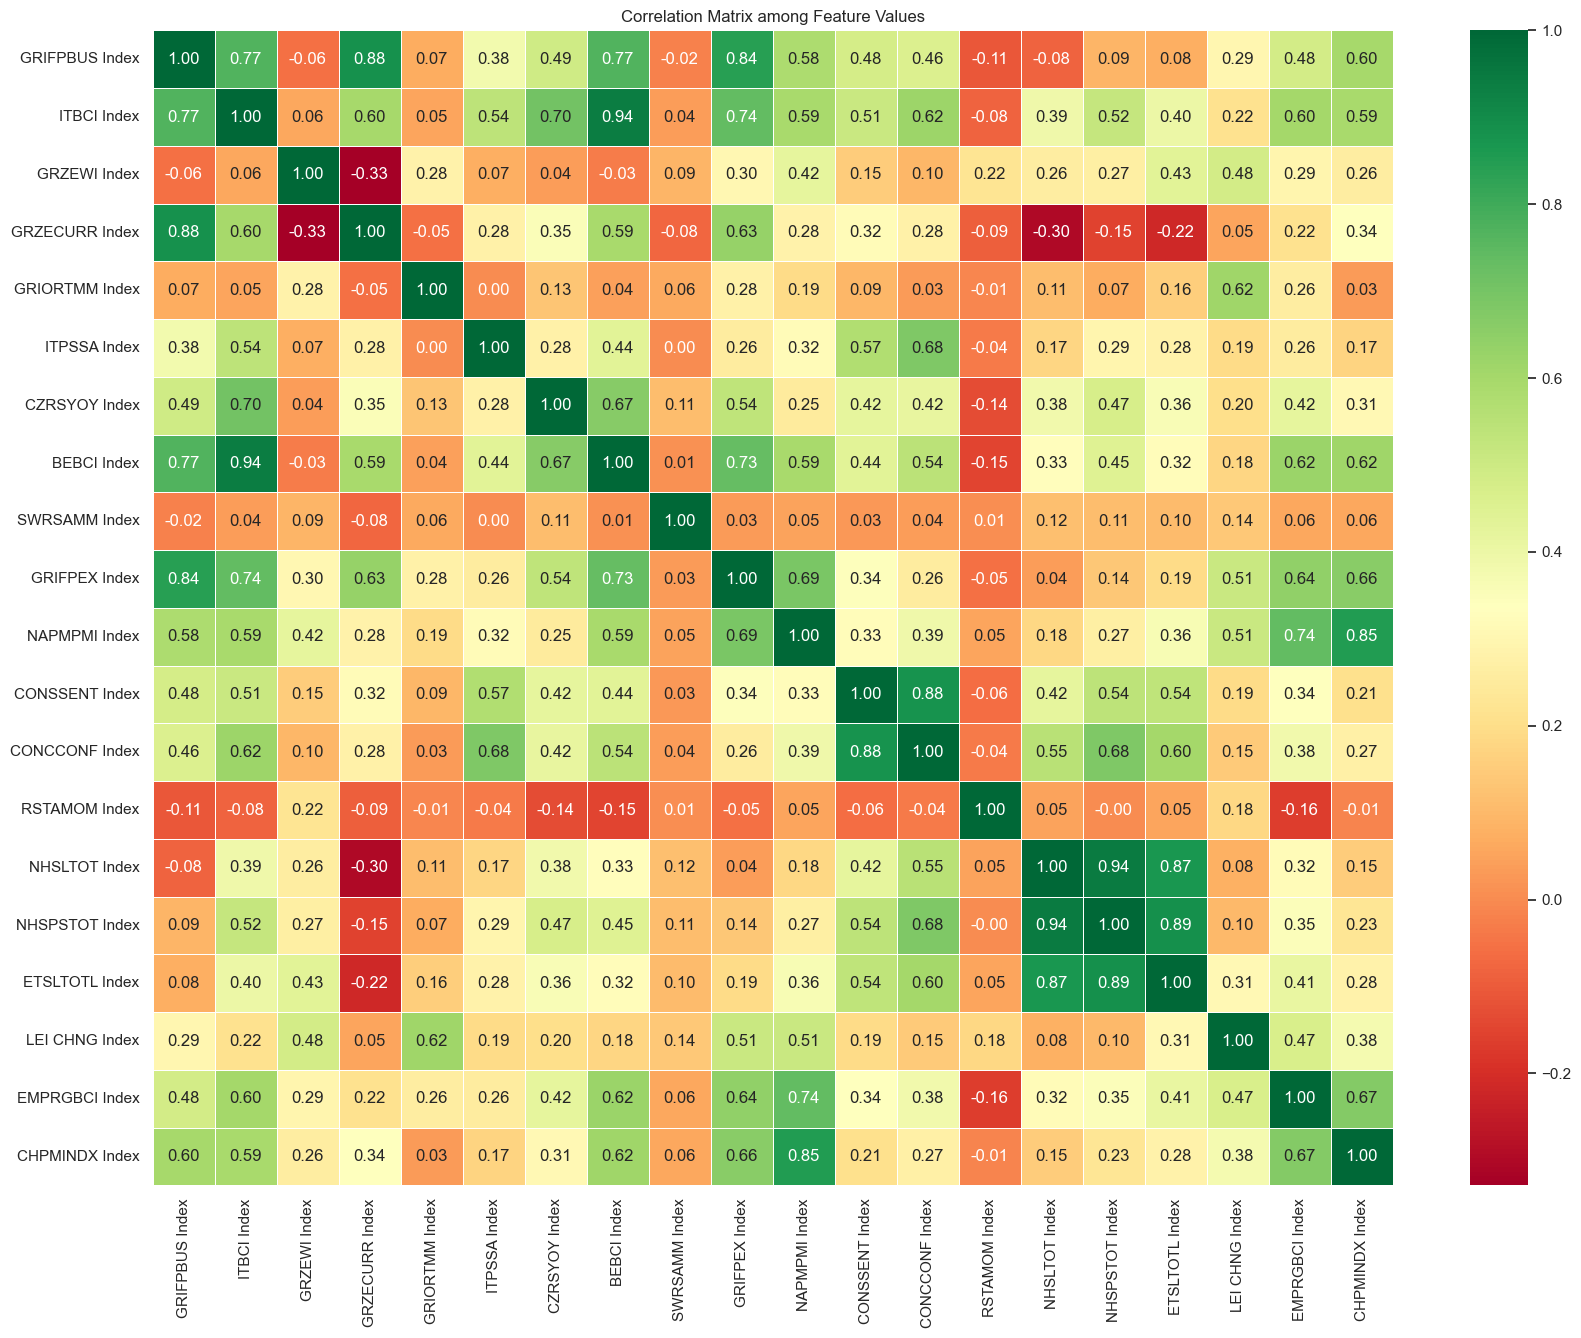

In [442]:
# Calculate the correlation matrix for the value columns
correlation_matrix = features_values.corr()

# Plot the correlation matrix
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='RdYlGn', linewidths=0.5, fmt=".2f")
plt.title('Correlation Matrix among Feature Values')
plt.show()

In [443]:
# APPLY TRANSFORMATION
# TRANSFORM DATA VALUE OF FEATURES
for column in  new_dataframe_adjusted_filtered.columns:
    if 'release date' in column :
        continue
    # Apply log transform to specific columns
    if column in ['GRIFPBUS Index', 'ITBCI Index','ITPSSA Index','GRIFPEX Index','SWETSURV Index',
                  'NAPMPMI Index','CONSSENT Index','CONCCONF Index','NHSLTOT Index', 'ETSLTOTL Index', 
                  'NHSPSTOT Index','CHPMINDX Index']:
        new_dataframe_adjusted_filtered.loc[:, column] = new_dataframe_adjusted_filtered[column].apply(lambda x: np.log(x) if x > 0 else np.nan)
    
    # Apply differencing transformation to the rest
    else:
        new_dataframe_adjusted_filtered.loc[:, column] = new_dataframe_adjusted_filtered[column].diff()


# Display the transformed dataframe
print("Transformed Features DataFrame:")
new_dataframe_adjusted_filtered

Transformed Features DataFrame:


,GRIFPBUS Index - release date,GRIFPBUS Index,ITBCI Index - release date,ITBCI Index,GRZEWI Index - release date,GRZEWI Index,GRZECURR Index - release date,GRZECURR Index,GRIORTMM Index - release date,GRIORTMM Index,...,NHSPSTOT Index - release date,NHSPSTOT Index,ETSLTOTL Index - release date,ETSLTOTL Index,LEI CHNG Index - release date,LEI CHNG Index,EMPRGBCI Index - release date,EMPRGBCI Index,CHPMINDX Index - release date,CHPMINDX Index
0,2004-12,4.523960,2004-12,4.631812,2004-12,NaN,2004-12,NaN,2005-02,NaN,...,2005-01,7.621685,2005-02,1.960095,2005-01,NaN,2004-12,NaN,2004-12,4.114147
1,2005-01,4.523960,2005-01,4.624973,2005-01,12.5,2005-01,3.0,2005-03,-9.0,...,2005-02,7.670429,2005-03,1.928619,2005-02,-0.4,2005-01,-6.0,2005-01,4.143135
2,2005-02,4.520701,2005-02,4.616110,2005-02,9.0,2005-02,2.5,2005-04,0.8,...,2005-03,7.699389,2005-04,1.940179,2005-03,0.0,2005-02,1.5,2005-02,4.178992
3,2005-03,4.500920,2005-03,4.605170,2005-03,0.4,2005-03,-7.3,2005-05,3.8,...,2005-04,7.530480,2005-05,1.962908,2005-04,-0.9,2005-03,7.2,2005-03,4.178992
4,2005-04,4.499810,2005-04,4.575741,2005-04,-16.2,2005-04,-7.0,2005-06,-2.8,...,2005-05,7.630947,2005-06,1.957274,2005-05,1.0,2005-04,-16.0,2005-04,4.182050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,2021-06,4.623992,2021-06,4.744932,2021-06,-4.6,2021-06,31.0,2021-08,8.0,...,2021-07,7.412764,2021-08,1.791759,2021-07,-0.6,2021-06,-6.9,2021-06,4.191169
199,2021-07,4.613138,2021-07,4.729156,2021-07,-16.5,2021-07,31.0,2021-09,0.3,...,2021-08,7.348588,2021-09,1.771557,2021-08,0.2,2021-07,25.6,2021-07,4.295924
200,2021-08,4.601162,2021-08,4.727388,2021-08,-22.9,2021-08,7.4,2021-10,-12.6,...,2021-09,7.387090,2021-10,1.771557,2021-09,0.1,2021-08,-24.7,2021-08,4.201703
201,2021-09,4.593098,2021-09,4.727388,2021-09,-13.9,2021-09,2.6,2021-11,0.0,...,2021-10,7.387090,2021-11,1.930071,2021-10,0.0,2021-09,16.0,2021-09,4.169761


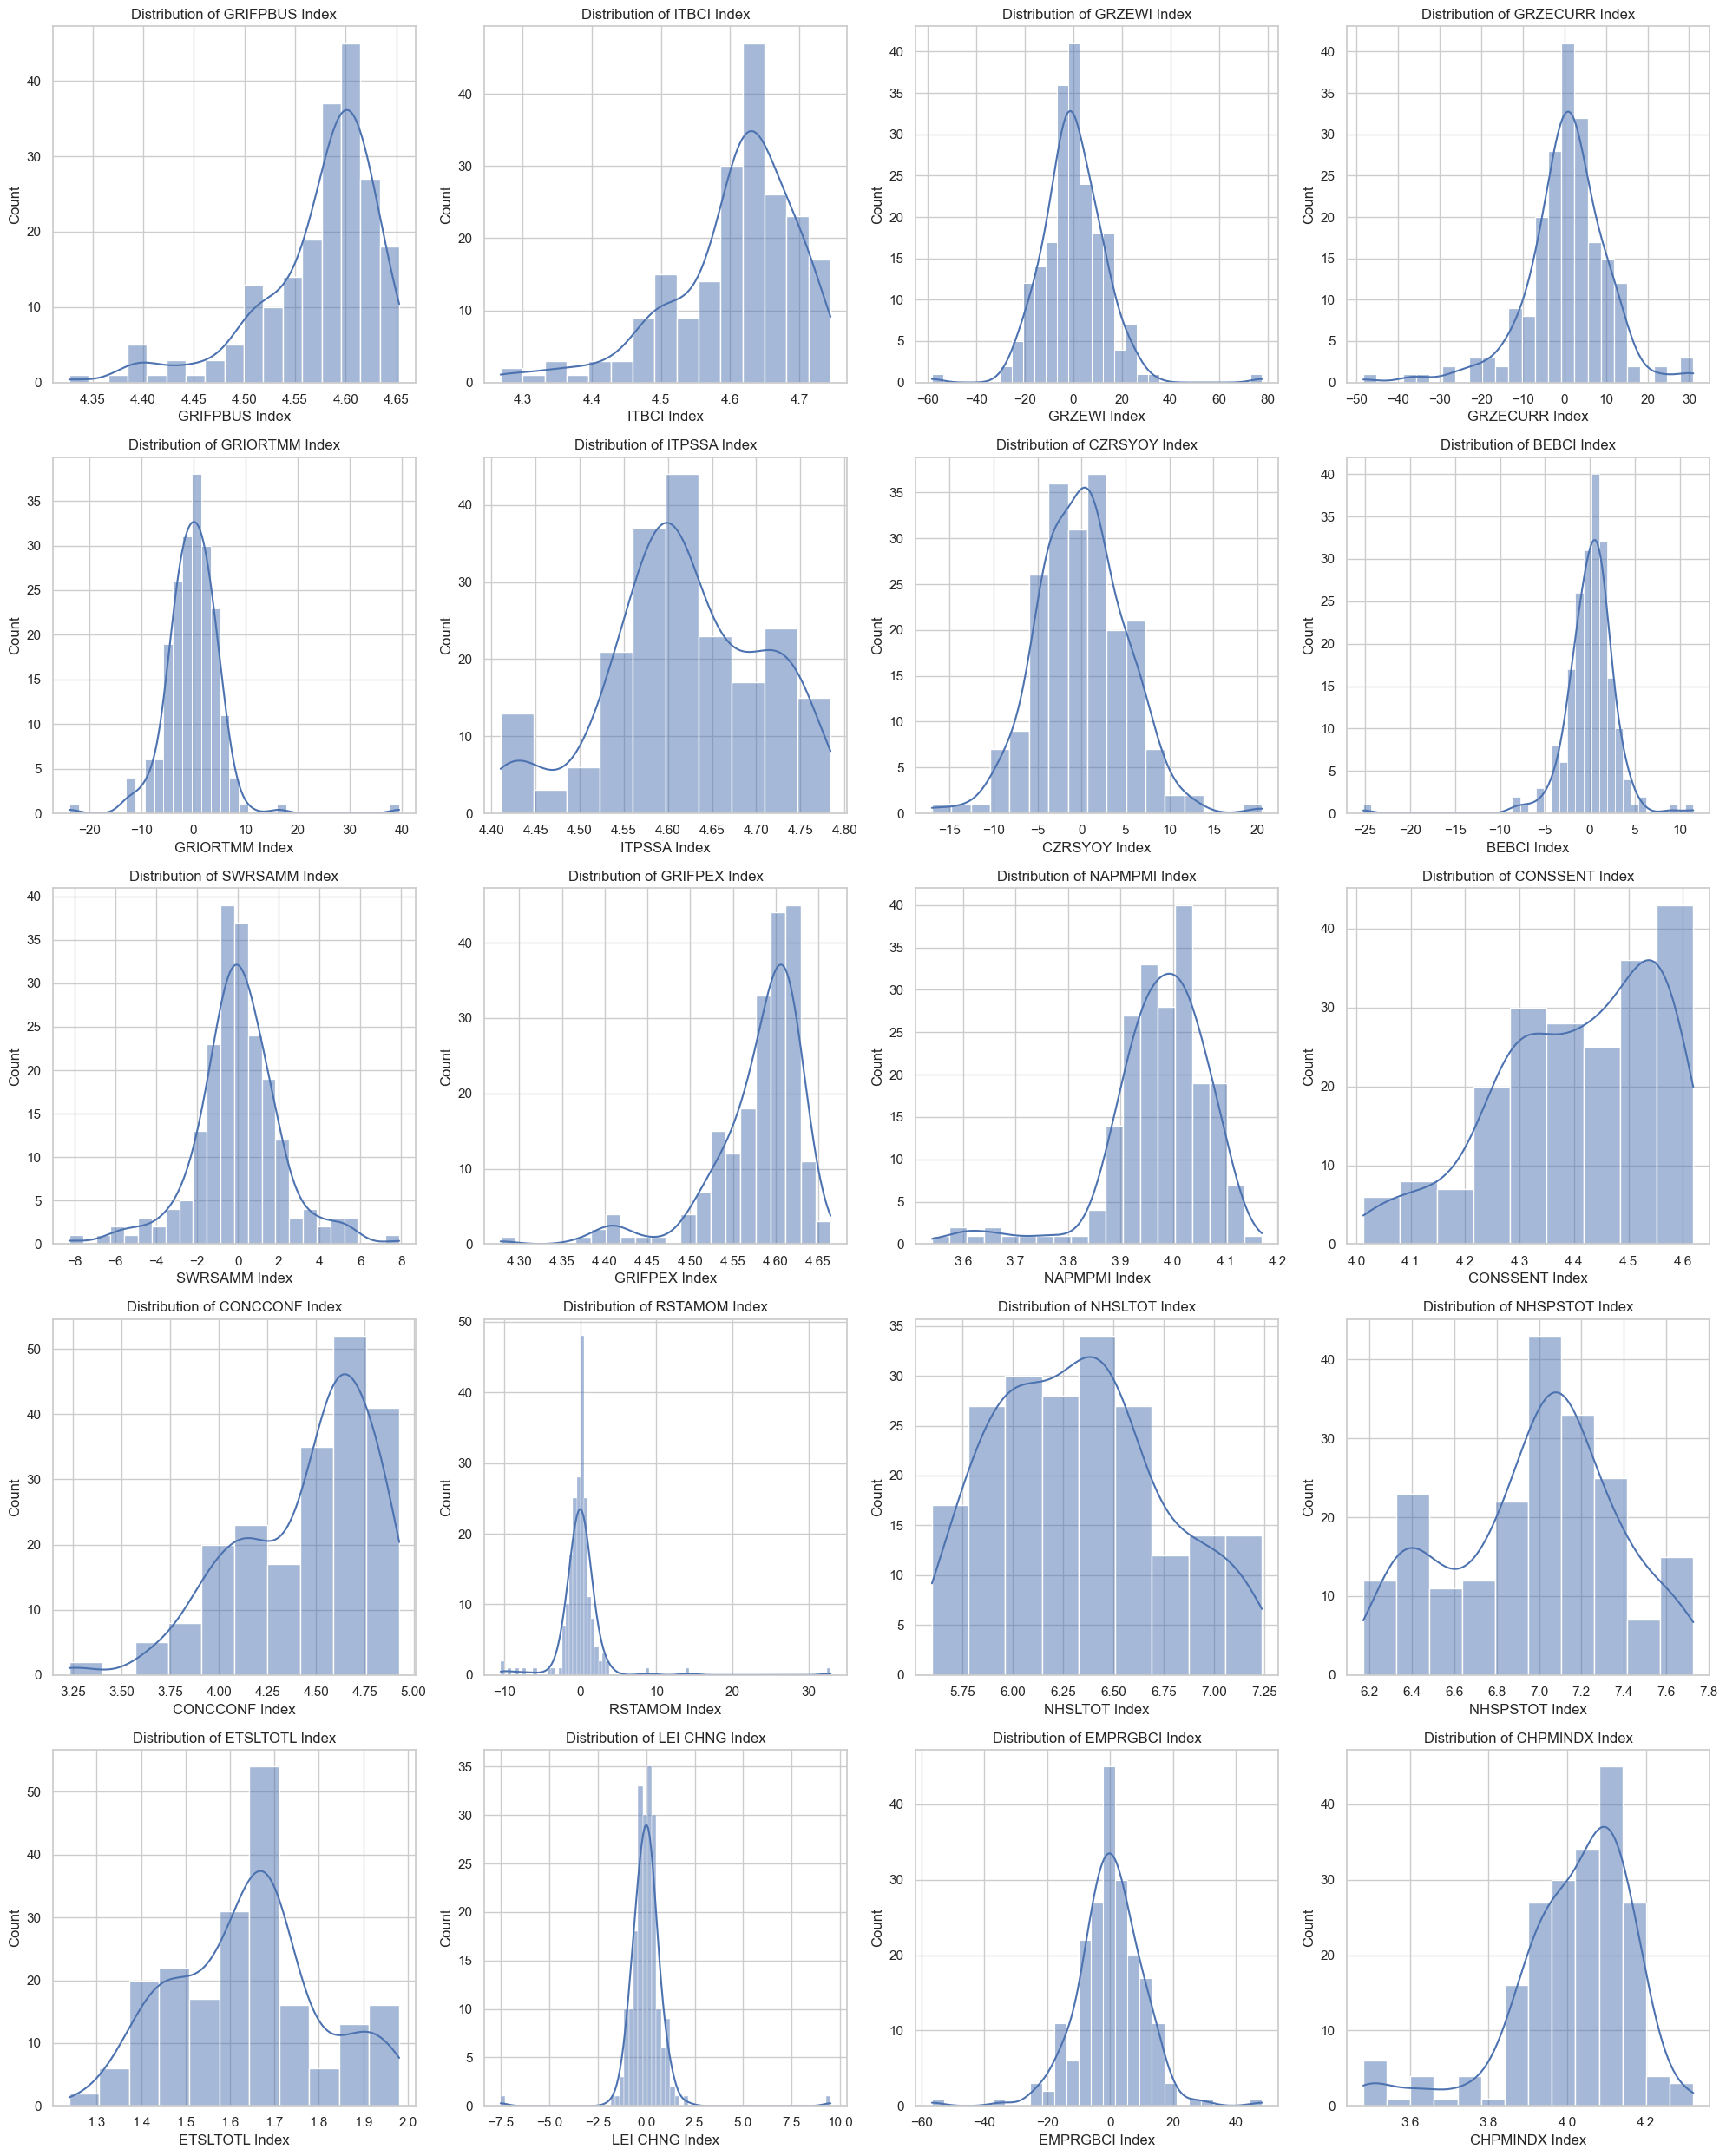

In [444]:
# Set the plotting style
sns.set(style="whitegrid")

# Extract only value columns (exclude 'release date' columns)
value_columns = [col for col in new_dataframe_adjusted_filtered.columns if 'release date' not in col]

# Number of features and the layout for subplots
num_features = len(value_columns)
num_plots_per_row = 4
num_rows = (num_features + num_plots_per_row - 1) // num_plots_per_row

# Create subplots to plot the distribution of each feature
fig, axes = plt.subplots(nrows=num_rows, ncols=num_plots_per_row, figsize=(20, num_rows * 5))
axes = axes.flatten()

for idx, feature in enumerate(value_columns):
    sns.histplot(new_dataframe_adjusted_filtered[feature].dropna(), kde=True, ax=axes[idx], color='b')
    axes[idx].set_title(f'Distribution of {feature}')

# Hide any unused subplots
for idx in range(num_features, len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

### Merge target and features

In [446]:
# Create a copy of the features and target dataframes
features_df = new_dataframe_adjusted_filtered.copy()
target_df = swap_df.copy()

# Reset index to make Year-Month a column in the target dataframe
# target_df.reset_index(inplace=True)

# Initialize the merged dataframe using target_df
merged_df = target_df.copy()

# Iterate over pairs of release date and feature value columns in features dataframe
for idx in range(0, len(features_df.columns), 2):
    # Extract release date column and value column names
    release_date_col = features_df.columns[idx]
    value_col = features_df.columns[idx + 1]
    
    # Prepare a temporary dataframe with the feature value and the corresponding release date
    feature_df = features_df[[release_date_col, value_col]].copy()

    # Rename the release date column to 'Year-Month' for merging
    feature_df.rename(columns={release_date_col: 'Year-Month'}, inplace=True)
    
    # Merge with target dataframe
    merged_df = pd.merge(merged_df, feature_df, on='Year-Month', how='left')

# Set the 'Year-Month' column as the index of the merged dataframe
merged_df.set_index('Year-Month', inplace=True)
merged_df = merged_df.loc[merged_df.index <= '2021-12']

# Display the merged dataframe
print("Merged DataFrame with Target and Features:")
merged_df

Merged DataFrame with Target and Features:


,y_6m_diff,GRIFPBUS Index,ITBCI Index,GRZEWI Index,GRZECURR Index,GRIORTMM Index,ITPSSA Index,CZRSYOY Index,BEBCI Index,SWRSAMM Index,...,NAPMPMI Index,CONSSENT Index,CONCCONF Index,RSTAMOM Index,NHSLTOT Index,NHSPSTOT Index,ETSLTOTL Index,LEI CHNG Index,EMPRGBCI Index,CHPMINDX Index
Year-Month,,,,,,,,,,,,,,,,,,,,,
2011-01,0.5237,4.621044,4.664382,11.1,0.2,4.9,4.603168,5.7,1.4,-1.47,...,4.036009,4.306764,4.171151,-0.6,5.786897,6.289716,1.451614,0.2,-2.3,4.188138
2011-02,0.8290,4.627910,4.643429,0.3,2.4,-8.5,4.587006,-4.7,1.3,1.47,...,4.079231,4.350278,4.276944,0.3,5.726848,6.445720,1.486140,-1.2,2.5,4.169761
2011-03,0.6000,4.624973,4.644391,-1.6,0.2,7.7,4.571613,7.2,0.4,-0.69,...,4.080922,4.212128,4.156067,0.0,5.598422,6.248043,1.425515,0.8,0.3,4.228293
2011-04,0.4020,4.627910,4.653008,-6.5,1.7,-3.3,4.568506,-2.0,-3.4,-1.37,...,4.067316,4.245634,4.189958,0.1,5.703782,6.396930,1.449269,0.1,6.7,4.191169
2011-05,0.2940,4.628887,4.652054,-4.5,4.4,-4.5,4.609162,-3.1,-3.3,5.21,...,4.058717,4.308111,4.122932,-0.4,5.736572,6.317165,1.427916,-0.9,-9.0,4.070735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08,-0.2696,4.601162,4.727388,-22.9,7.4,8.0,4.784153,-9.2,-2.5,-0.34,...,4.085976,4.252772,4.746670,2.5,6.591674,7.348588,1.791759,0.2,-24.7,4.201703
2021-09,-0.2956,4.593098,4.727388,-13.9,2.6,0.3,4.784153,-8.8,-3.6,1.92,...,4.092677,4.287716,4.694096,-0.2,6.606650,7.387090,1.771557,0.1,16.0,4.169761
2021-10,-0.4446,4.593098,4.727388,-4.2,-10.3,-12.6,4.784153,3.2,0.0,0.00,...,4.112512,4.268298,4.694096,0.0,6.606650,7.387090,1.771557,0.0,-14.5,4.169761


In [447]:
na_rows = merged_df[merged_df.isna().any(axis=1)]

# Extract the 'Year-Month' index values that contain NaN
na_month_years = na_rows.index.unique()

# Display the 'Year-Month' values with NaN
print("Year-Month values with NaN:")
na_month_years

Year-Month values with NaN:


Index(['2021-11', '2021-12'], dtype='object', name='Year-Month')

In [448]:
# Drop rows with any NaN values in merged_df
merged_df_cleaned = merged_df.dropna()

# Display the cleaned dataframe
print("Cleaned DataFrame (with NaN rows dropped):")
merged_df_cleaned

Cleaned DataFrame (with NaN rows dropped):


,y_6m_diff,GRIFPBUS Index,ITBCI Index,GRZEWI Index,GRZECURR Index,GRIORTMM Index,ITPSSA Index,CZRSYOY Index,BEBCI Index,SWRSAMM Index,...,NAPMPMI Index,CONSSENT Index,CONCCONF Index,RSTAMOM Index,NHSLTOT Index,NHSPSTOT Index,ETSLTOTL Index,LEI CHNG Index,EMPRGBCI Index,CHPMINDX Index
Year-Month,,,,,,,,,,,,,,,,,,,,,
2011-01,0.5237,4.621044,4.664382,11.1,0.2,4.9,4.603168,5.7,1.4,-1.47,...,4.036009,4.306764,4.171151,-0.6,5.786897,6.289716,1.451614,0.2,-2.3,4.188138
2011-02,0.8290,4.627910,4.643429,0.3,2.4,-8.5,4.587006,-4.7,1.3,1.47,...,4.079231,4.350278,4.276944,0.3,5.726848,6.445720,1.486140,-1.2,2.5,4.169761
2011-03,0.6000,4.624973,4.644391,-1.6,0.2,7.7,4.571613,7.2,0.4,-0.69,...,4.080922,4.212128,4.156067,0.0,5.598422,6.248043,1.425515,0.8,0.3,4.228293
2011-04,0.4020,4.627910,4.653008,-6.5,1.7,-3.3,4.568506,-2.0,-3.4,-1.37,...,4.067316,4.245634,4.189958,0.1,5.703782,6.396930,1.449269,0.1,6.7,4.191169
2011-05,0.2940,4.628887,4.652054,-4.5,4.4,-4.5,4.609162,-3.1,-3.3,5.21,...,4.058717,4.308111,4.122932,-0.4,5.736572,6.317165,1.427916,-0.9,-9.0,4.070735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06,0.3515,4.623992,4.744932,-4.6,31.0,-1.8,4.758749,6.0,3.3,2.87,...,4.114147,4.448516,4.859037,2.3,6.597146,7.374002,1.754404,-0.1,-6.9,4.191169
2021-07,0.1200,4.613138,4.729156,-16.5,31.0,-4.8,4.755313,-3.1,0.3,-3.53,...,4.104295,4.396915,4.829113,-2.5,6.529419,7.412764,1.769855,-0.6,25.6,4.295924
2021-08,-0.2696,4.601162,4.727388,-22.9,7.4,8.0,4.784153,-9.2,-2.5,-0.34,...,4.085976,4.252772,4.746670,2.5,6.591674,7.348588,1.791759,0.2,-24.7,4.201703


In [509]:
merged_df_cleaned.to_csv(r'C:\Users\Admin\Downloads\BLP\merged_df.csv')

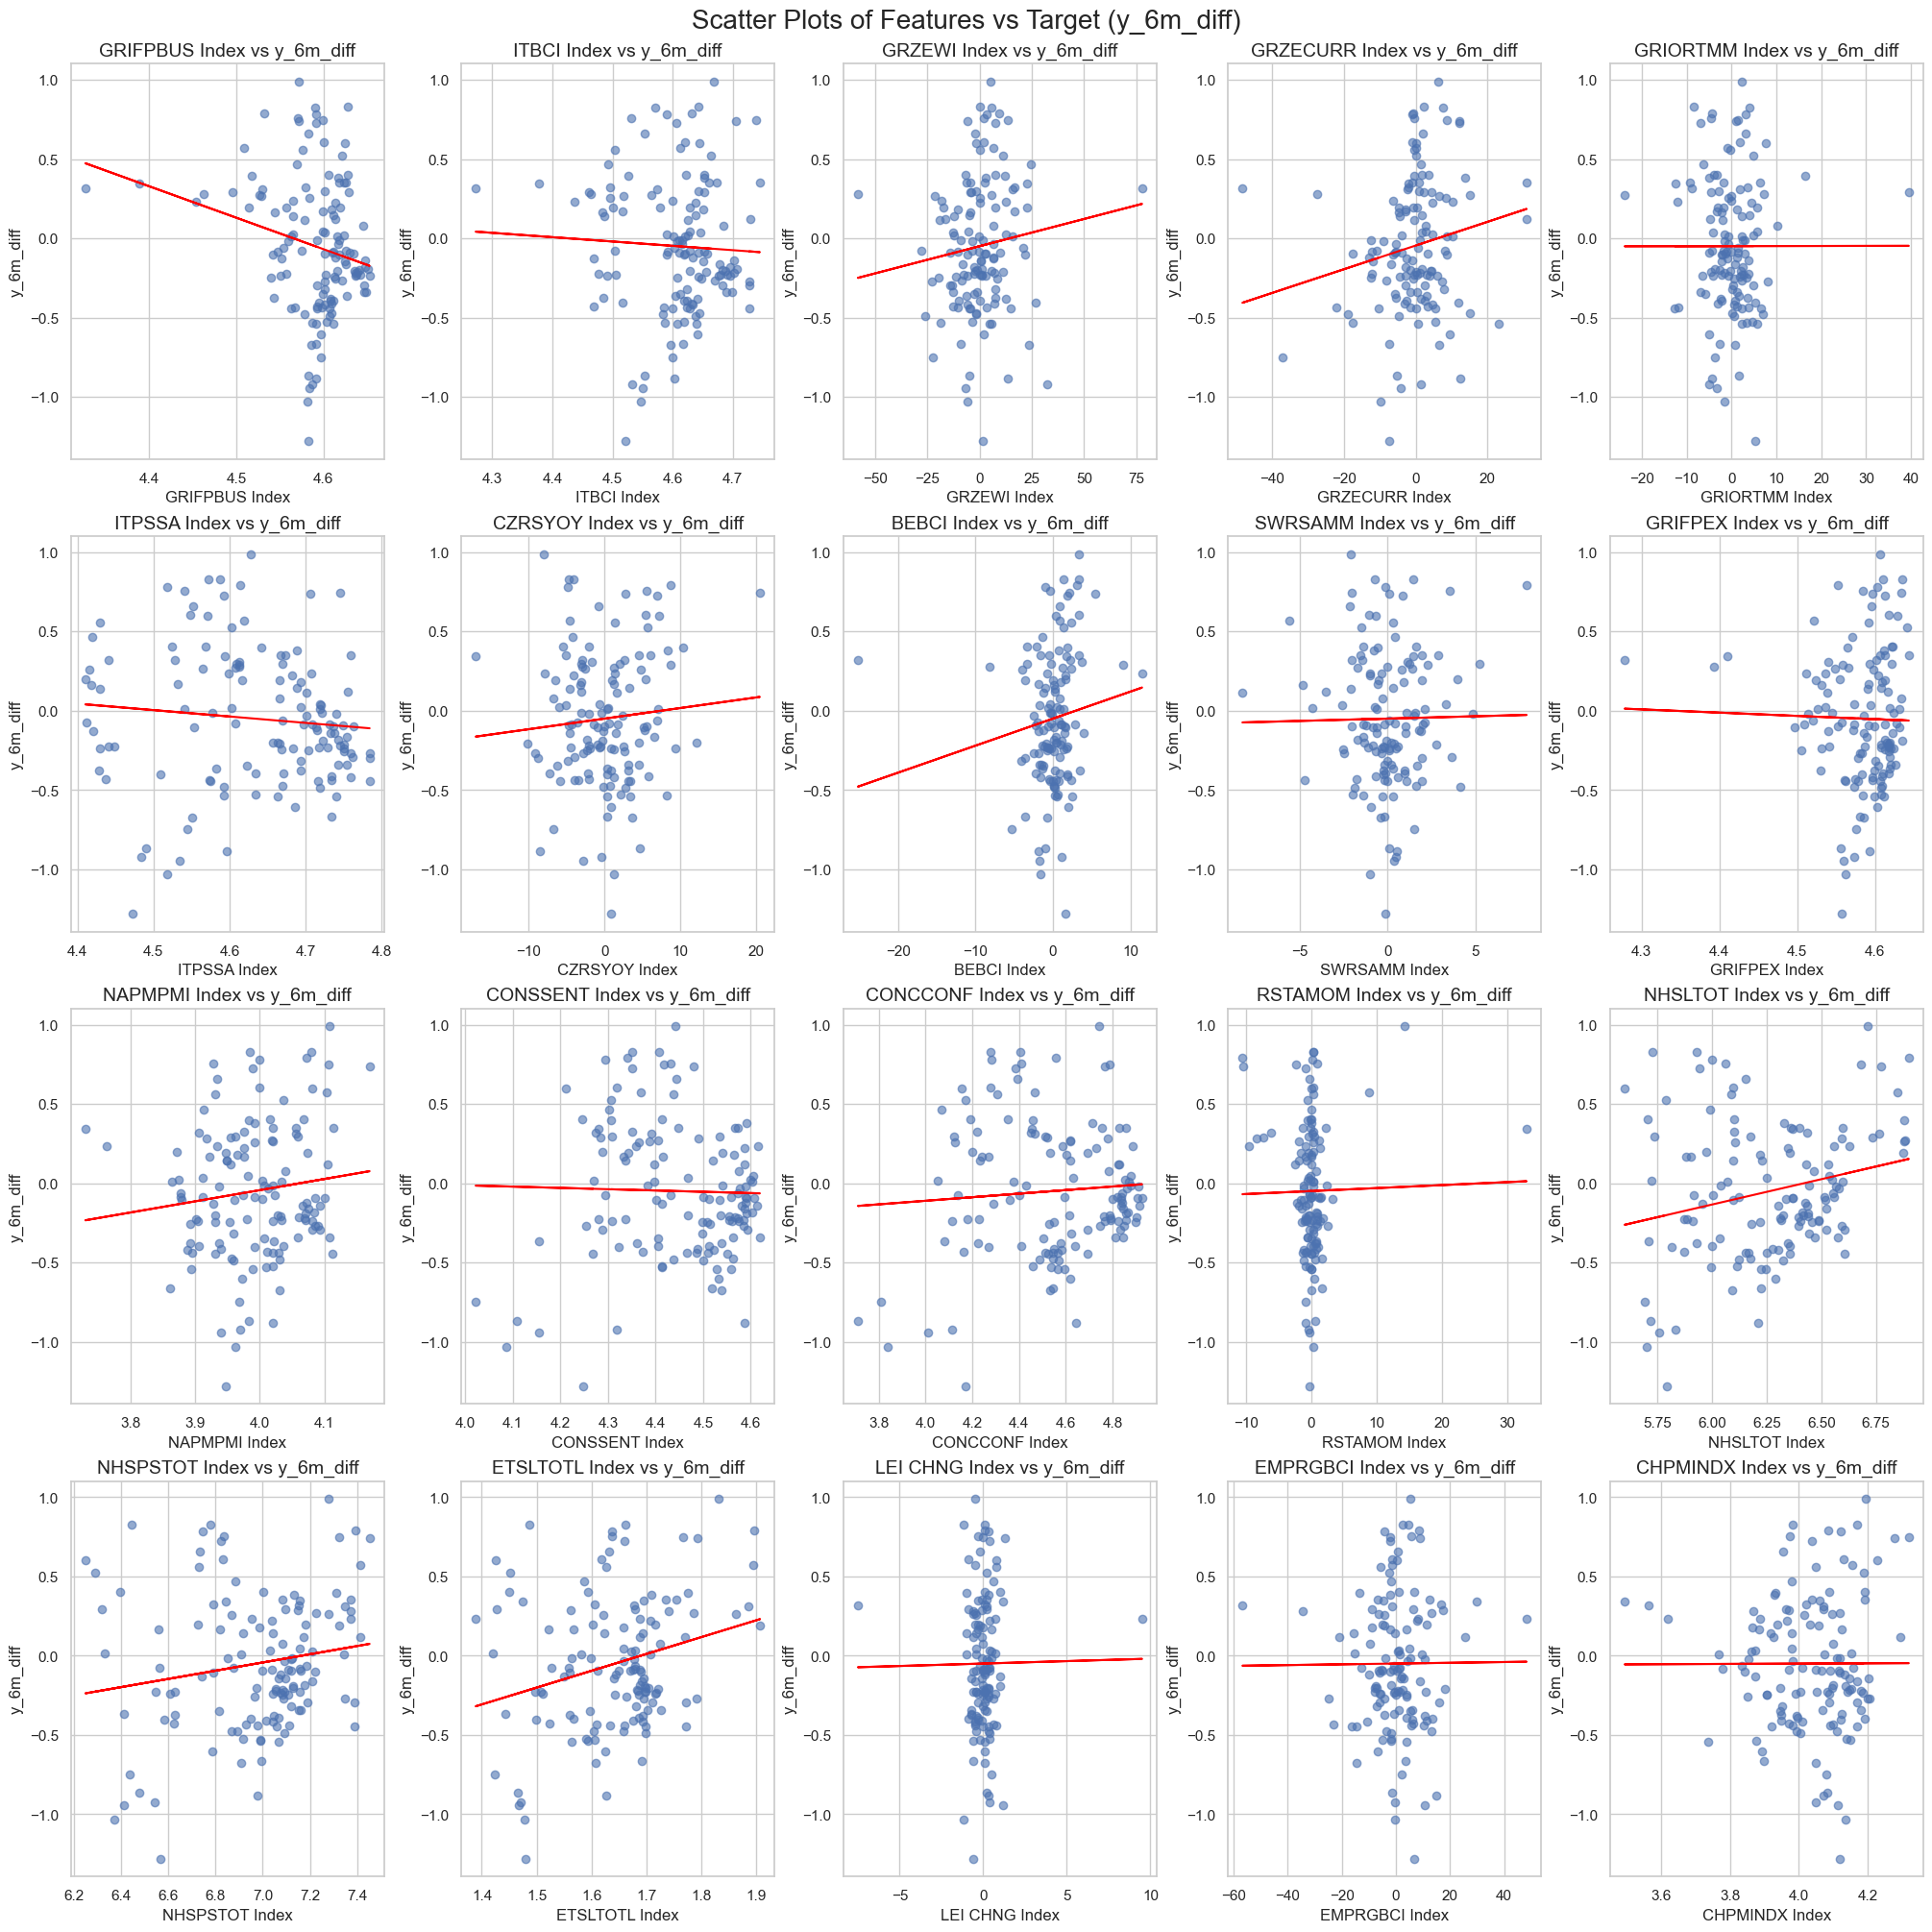

In [511]:
# Get all feature columns excluding 'y_6m_diff' and 'Year-Month'
features_columns = [col for col in merged_df_cleaned.columns if col != 'y_6m_diff' and col != 'Year-Month']

# Define the layout of subplots
num_features = len(features_columns)
num_plots_per_row = 5
num_rows = (num_features + num_plots_per_row - 1) // num_plots_per_row  # Calculate the required number of rows

# Set up the subplots
fig, axs = plt.subplots(num_rows, num_plots_per_row, figsize=(20, num_rows * 5), constrained_layout=True)
fig.suptitle('Scatter Plots of Features vs Target (y_6m_diff)', fontsize=20)

# Flatten the axs array to make iterating easier
axs = axs.flatten()

# Plot each feature vs the target
(row, col) = (0, 0)

for idx, feature in enumerate(features_columns):
    ax = axs[idx]
    
    # Extract x and y values
    x = merged_df_cleaned[feature]
    y = merged_df_cleaned['y_6m_diff']
    
    # Scatter plot of feature vs target
    ax.scatter(x, y, alpha=0.6)
    
    # Fit a regression line
    (m, q) = np.polyfit(x, y, deg=1)  # Linear regression coefficients
    
    # Plot regression line
    ax.plot(x, m * x + q, c='red')
    
    # Set labels and title for each subplot
    ax.set_xlabel(feature)
    ax.set_ylabel('y_6m_diff')
    ax.set_title(f'{feature} vs y_6m_diff', fontsize=14)
    
    # Add grid lines for better readability
    ax.grid(True)

# Hide any unused subplots
for idx in range(num_features, len(axs)):
    axs[idx].set_visible(False)

plt.show()

In [451]:

# Assuming merged_df is your combined dataset of features and target with 'y_6m_diff' as target column

target_column = 'y_6m_diff'
features = [col for col in merged_df.columns if col != target_column and 'release date' not in col and col != 'Year-Month']

# Initialize dictionaries to store correlation results
pearson_corr = {}
spearman_corr = {}

# Calculate Pearson and Spearman correlations for each feature against the target
for feature in features:
    # Pearson correlation
    pearson_corr[feature] = merged_df[feature].corr(merged_df[target_column])

    # Spearman rank correlation
    spearman_corr[feature], _ = stats.spearmanr(merged_df[feature], merged_df[target_column], nan_policy='omit')

# Create a summary DataFrame for both correlations
correlation_summary = pd.DataFrame({
    'Feature': features,
    'Pearson Correlation': [pearson_corr[feature] for feature in features],
    'Spearman Correlation': [spearman_corr[feature] for feature in features]
})

# Display the summary DataFrame
print("Correlation Summary for Each Feature:")
correlation_summary

Correlation Summary for Each Feature:


,Feature,Pearson Correlation,Spearman Correlation
0,GRIFPBUS Index,-0.217971,-0.154375
1,ITBCI Index,-0.048972,-0.038023
2,GRZEWI Index,0.112445,0.178356
3,GRZECURR Index,0.173484,0.177617
4,GRIORTMM Index,0.000429,-0.044162
5,ITPSSA Index,-0.097489,-0.176629
6,CZRSYOY Index,0.078795,0.024710
7,BEBCI Index,0.128020,0.218651
8,SWRSAMM Index,0.013912,-0.029499
9,GRIFPEX Index,-0.023290,0.053308


### 2. MODELLING

In [452]:
# Split the data into training and test sets
test_set = merged_df_cleaned.iloc[-36:]  # Get the last 36 rows for the test set
training_set = merged_df_cleaned.iloc[:-36]  # Get all rows except the last 36 for the training set

In [453]:
# Define the features and target variable for training and test sets
X_train = training_set.drop(columns=['y_6m_diff'])
y_train = training_set['y_6m_diff']

X_test = test_set.drop(columns=['y_6m_diff'])
y_test = test_set['y_6m_diff']

### 2.1 Stepwise Regression

In [472]:
X_train_with_const = sm.add_constant(X_train, has_constant='add')
# Stepwise Selection Method
def stepwise_selection(X, y, initial_list=[], threshold_in=0.05, threshold_out=0.1, verbose=True):
    included = list(initial_list)
   
    while True:
        changed = False

        # Forward Step: Test each excluded feature for inclusion
        excluded = list(set(X.columns) - set(included)) #list of features that are not currently included
        new_pval = pd.Series(index=excluded, dtype=float) # store the p-value for each feature not currently included

        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(X[included + [new_column]])).fit() #fit OLS and calculate p-value for that feature
            new_pval[new_column] = model.pvalues[new_column]

        best_pval = new_pval.min()
        if best_pval < threshold_in:#feature with smallest p-value and if it is below threshold_in
            best_feature = new_pval.idxmin()
            included.append(best_feature) # add it to the model
            changed = True
            if verbose:
                print(f'Add  {best_feature} with p-value {best_pval}')

        # Backward Step: Test each included feature for exclusion
        model = sm.OLS(y, sm.add_constant(X[included])).fit()
        pvalues = model.pvalues.iloc[1:]  # Exclude the constant (`const`) from being dropped

        worst_pval = pvalues.max()
        if worst_pval > threshold_out:
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            changed = True
            if verbose:
                print(f'Drop {worst_feature} with p-value {worst_pval}')
     
        if not changed:
            break
            
    return included

# Perform stepwise feature selection using training data
# No need to add constant before passing to stepwise_selection function
selected_features = stepwise_selection(X_train, y_train)

# Train the final model using the selected features from the training set
# Add constant only to the selected features for final model training
X_selected_train = X_train[selected_features]
X_selected_train_with_const = sm.add_constant(X_selected_train, has_constant='add')

# Fit the OLS model
final_model = sm.OLS(y_train, X_selected_train_with_const).fit()

# Display results of the final model
print(final_model.summary())

Add  GRIFPEX Index with p-value 0.0013064251441023346
Add  ITPSSA Index with p-value 1.608354550819898e-05
Add  ETSLTOTL Index with p-value 0.0005136148322723488
Add  NHSLTOT Index with p-value 0.0009678868493614711
                            OLS Regression Results                            
Dep. Variable:              y_6m_diff   R-squared:                       0.438
Model:                            OLS   Adj. R-squared:                  0.413
Method:                 Least Squares   F-statistic:                     17.34
Date:                Sat, 23 Nov 2024   Prob (F-statistic):           1.49e-10
Time:                        19:22:00   Log-Likelihood:                -29.037
No. Observations:                  94   AIC:                             68.07
Df Residuals:                      89   BIC:                             80.79
Df Model:                           4                                         
Covariance Type:            nonrobust                                    

In [465]:
from sklearn.metrics import mean_squared_error

# Predict using the training set
y_train_pred = final_model.predict(X_selected_train_with_const)

# Calculate the Mean Squared Error (MSE) on the training set
mse_train = mean_squared_error(y_train, y_train_pred)

# Print the Mean Squared Error (MSE) on the training set
print(f"Mean Squared Error (MSE) on Training Set: {mse_train:.4f}")

Mean Squared Error (MSE) on Training Set: 0.1086


In [507]:
from scipy.stats import jarque_bera
residuals = final_model.resid
# Perform the Jarque-Bera test on the residuals
jb_stat, jb_p_value = jarque_bera(residuals)

# Display the test statistic and p-value
print("Jarque-Bera Test Statistic:", jb_stat)
print("Jarque-Bera Test p-value:", jb_p_value)

# Interpret the result
alpha = 0.05
if jb_p_value > alpha:
    print("Fail to reject the null hypothesis - Residuals are likely normally distributed.")
else:
    print("Reject the null hypothesis - Residuals are likely not normally distributed.")

Jarque-Bera Test Statistic: 1.8297843878870033
Jarque-Bera Test p-value: 0.4005598065363547
Fail to reject the null hypothesis - Residuals are likely normally distributed.


### 2.2 LASSO

In [457]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Function to fit Lasso with specified alpha and evaluate
def fit_and_evaluate_lasso(alpha_value):
    # Fit Lasso model
    lasso = Lasso(alpha=alpha_value, random_state=0)
    lasso.fit(X_train_scaled, y_train)

    # Predict on test set
    y_pred_lasso = lasso.predict(X_test_scaled)

    # Calculate performance metrics
    mse = mean_squared_error(y_test, y_pred_lasso)
    r2 = r2_score(y_test, y_pred_lasso)

    # Display selected features
    selected_features_mask = lasso.coef_ != 0
    selected_features_lasso = np.array(X_train.columns)[selected_features_mask]
    selected_coefficients = lasso.coef_[selected_features_mask]
    
    print(f"\nLasso with alpha = {alpha_value}")
    print("Selected Features:", selected_features_lasso)
    print("Mean Squared Error (MSE):", mse)
    print("R-squared:", r2)
    
    # Display the selected coefficients
    print("Coefficients for Selected Features:")
    for feature, coef in zip(selected_features_lasso, selected_coefficients):
        print(f"{feature}: {coef:.4f}")

    return mse, r2, selected_features_lasso, selected_coefficients

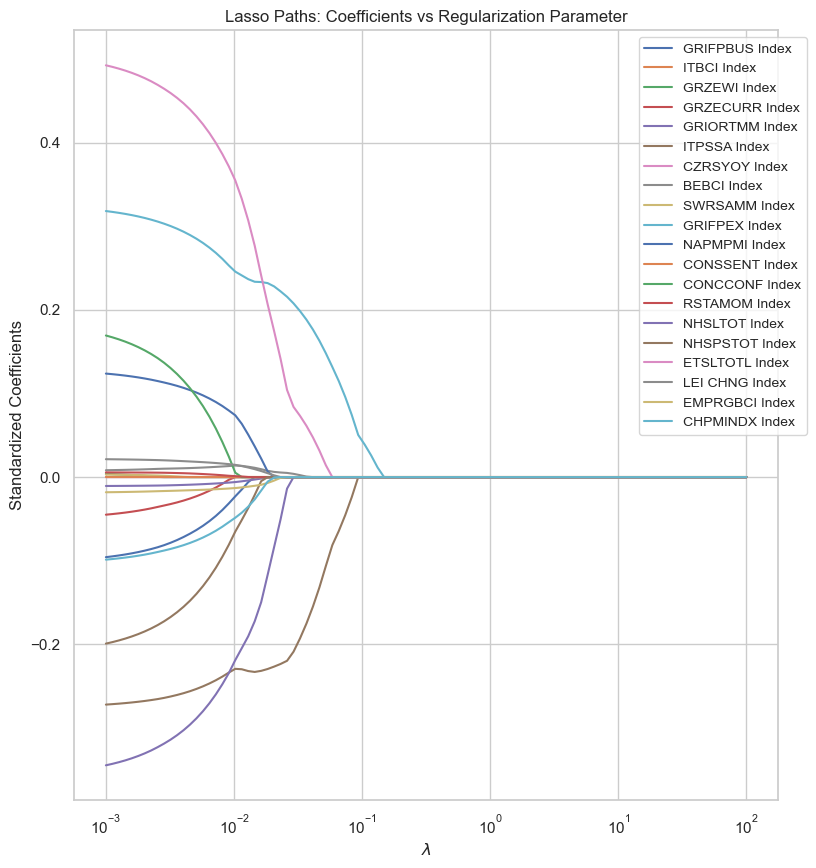

In [510]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Set a range of alpha values
alphas = np.logspace(-3, 2, 100)  # Logarithmically spaced values between 10^-3 and 10^2

# Prepare to store coefficients for each alpha value
coefs = []

# Fit Lasso model for each alpha value and store the coefficients
for alpha in alphas:
    lasso = Lasso(alpha=alpha, random_state=0)
    lasso.fit(X_train_scaled, y_train)
    coefs.append(lasso.coef_)

coefs = np.array(coefs)

# Plotting the Lasso path (standardized coefficients vs log(alpha))
plt.figure(figsize=(20, 10))

# Plot coefficients for each alpha value
plt.subplot(1, 2, 1)
ax = plt.gca()
for idx, feature in enumerate(X_train.columns):
    ax.plot(alphas, coefs[:, idx], label=feature)

ax.set_xscale('log')
plt.xlabel(r'$\lambda$')
plt.ylabel('Standardized Coefficients')
plt.title('Lasso Paths: Coefficients vs Regularization Parameter')
plt.grid(True)
plt.legend(loc='best', bbox_to_anchor=(1.05, 1), fontsize='small')  # Adding a legend with feature names

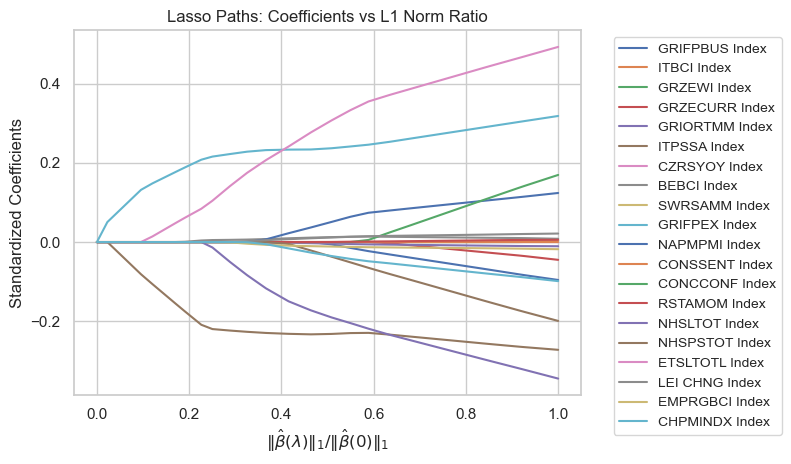

In [488]:
# Re-plot coefficients normalized by the L1 norm of the coefficients
l1_norms = np.sum(np.abs(coefs), axis=1)
l1_ratios = l1_norms / l1_norms.max()

plt.subplot(1, 2, 2)
for idx, feature in enumerate(X_train.columns):
    plt.plot(l1_ratios, coefs[:, idx], label=feature)
    
plt.xlabel(r'$\|\hat{\beta}(\lambda)\|_1 / \|\hat{\beta}(0)\|_1$')
plt.ylabel('Standardized Coefficients')
plt.title('Lasso Paths: Coefficients vs L1 Norm Ratio')
plt.grid(True)
plt.legend(loc='best', bbox_to_anchor=(1.05, 1), fontsize='small')  # Adding a legend with feature names

plt.tight_layout()
plt.subplots_adjust(right=2)
plt.show()

In [490]:
# Perform Lasso Regression for alpha = 0.01
mse_alpha_0_01, r2_alpha_0_01, selected_features_alpha_0_01, coefficients_alpha_0_01 = fit_and_evaluate_lasso(alpha_value=0.01)

# Perform Lasso Regression for alpha = 0.1
mse_alpha_0_04, r2_alpha_0_04, selected_features_alpha_0_04, coefficients_alpha_0_04 = fit_and_evaluate_lasso(alpha_value=0.04)

# Compare Lasso models with different alpha values
print("\nComparison of Lasso Models:")
print(f"Alpha = 0.01: MSE = {mse_alpha_0_01}")
print(f"Alpha = 0.04: MSE = {mse_alpha_0_04}")


Lasso with alpha = 0.01
Selected Features: ['GRIFPBUS Index' 'GRIORTMM Index' 'ITPSSA Index' 'BEBCI Index'
 'GRIFPEX Index' 'NAPMPMI Index' 'CONCCONF Index' 'RSTAMOM Index'
 'NHSLTOT Index' 'NHSPSTOT Index' 'ETSLTOTL Index' 'LEI CHNG Index'
 'EMPRGBCI Index' 'CHPMINDX Index']
Mean Squared Error (MSE): 1.5579900639097444
R-squared: -14.036064611712659
Coefficients for Selected Features:
GRIFPBUS Index: -0.0246
GRIORTMM Index: -0.0060
ITPSSA Index: -0.2298
BEBCI Index: 0.0137
GRIFPEX Index: 0.2468
NAPMPMI Index: 0.0750
CONCCONF Index: 0.0090
RSTAMOM Index: 0.0012
NHSLTOT Index: -0.2221
NHSPSTOT Index: -0.0682
ETSLTOTL Index: 0.3583
LEI CHNG Index: 0.0149
EMPRGBCI Index: -0.0132
CHPMINDX Index: -0.0495

Lasso with alpha = 0.04
Selected Features: ['ITPSSA Index' 'GRIFPEX Index' 'ETSLTOTL Index']
Mean Squared Error (MSE): 0.795090189168343
R-squared: -6.67336566092928
Coefficients for Selected Features:
ITPSSA Index: -0.1607
GRIFPEX Index: 0.1799
ETSLTOTL Index: 0.0516

Comparison of Lasso

In [491]:
print("\nSelected Features and Coefficients for Alpha = 0.04:")
for feature, coef in zip(selected_features_alpha_0_04, coefficients_alpha_0_04):
    print(f"{feature}: {coef:.4f}")


Selected Features and Coefficients for Alpha = 0.04:
ITPSSA Index: -0.1607
GRIFPEX Index: 0.1799
ETSLTOTL Index: 0.0516


In [494]:
selected_feature = ['ITPSSA Index', 'GRIFPEX Index', 'ETSLTOTL Index']
X_train_selected = X_train[selected_feature]
X_train_selected_with_const = sm.add_constant(X_train_selected, has_constant='add')
ols_model = sm.OLS(y_train, X_train_selected_with_const).fit()

print("\nOLS Model Summary:")
print(ols_model.summary())


OLS Model Summary:
                            OLS Regression Results                            
Dep. Variable:              y_6m_diff   R-squared:                       0.364
Model:                            OLS   Adj. R-squared:                  0.343
Method:                 Least Squares   F-statistic:                     17.20
Date:                Sun, 24 Nov 2024   Prob (F-statistic):           6.50e-09
Time:                        13:18:39   Log-Likelihood:                -34.819
No. Observations:                  94   AIC:                             77.64
Df Residuals:                      90   BIC:                             87.81
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -40.887

In [495]:
# Predict on the train set using the OLS model
y_train_pred_ols = ols_model.predict(X_train_selected_with_const)

# Calculate Mean Squared Error (MSE) on the train set
mse_train_ols = mean_squared_error(y_train, y_train_pred_ols)
print(f"Mean Squared Error (MSE) on Train Set using OLS: {mse_train_ols:.4f}")

Mean Squared Error (MSE) on Train Set using OLS: 0.1228


In [506]:
from scipy.stats import jarque_bera
# Perform the Jarque-Bera test on the residuals
jb_stat, jb_p_value = jarque_bera(residuals)

# Display the test statistic and p-value
print("Jarque-Bera Test Statistic:", jb_stat)
print("Jarque-Bera Test p-value:", jb_p_value)

# Interpret the result
alpha = 0.05
if jb_p_value > alpha:
    print("Fail to reject the null hypothesis - Residuals are likely normally distributed.")
else:
    print("Reject the null hypothesis - Residuals are likely not normally distributed.")

Jarque-Bera Test Statistic: 2.105115769388312
Jarque-Bera Test p-value: 0.3490437925051694
Fail to reject the null hypothesis - Residuals are likely normally distributed.


### 2.3 Model Evaluation and Comparison
#### Model Evaluation of model built by Stepwise Regression

In [496]:
# Fitting on test set
# Use only the selected features to create the test feature set
X_selected_test = X_test[selected_features]
X_selected_test_with_const = sm.add_constant(X_selected_test, has_constant='add')
y_pred_stepwise = final_model.predict(X_selected_test_with_const)

# Metrics for Stepwise Regression
mse_stepwise = mean_squared_error(y_test, y_pred_stepwise)

# Print the performance metrics and the summary of the final model
print("Stepwise Regression Performance:")
print("Mean Squared Error (MSE) on test set:", mse_stepwise)


Stepwise Regression Performance:
Mean Squared Error (MSE) on test set: 2.2798385568281603


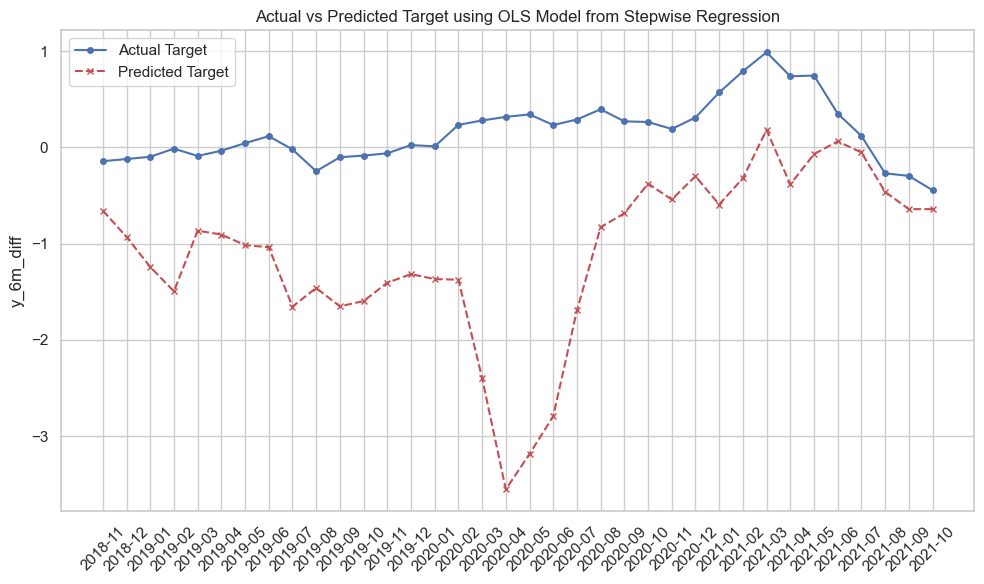

In [503]:
# Plotting the true vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label="Actual Target", color='b', linestyle='-', marker='o', markersize=4)
plt.plot(y_test.index, y_pred_stepwise, label="Predicted Target", color='r', linestyle='--', marker='x', markersize=4)

plt.ylabel('y_6m_diff')
plt.title('Actual vs Predicted Target using OLS Model from Stepwise Regression')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()

#### Model Evaluation of model built by LASSO

In [498]:
# Extract the selected feature for the test set
X_test_selected = X_test[selected_feature]

# Add a constant to the feature set for the intercept
X_test_selected_with_const = sm.add_constant(X_test_selected, has_constant='add')

# Predict on the test set using the OLS model
y_test_pred_ols = ols_model.predict(X_test_selected_with_const)

# Calculate Mean Squared Error (MSE) on the test set
mse_test_ols = mean_squared_error(y_test, y_test_pred_ols)

# Print the Mean Squared Error (MSE) on the test set and the OLS summary
print(f"Mean Squared Error (MSE) on Test Set using OLS: {mse_test_ols:.4f}")

Mean Squared Error (MSE) on Test Set using OLS: 1.4429


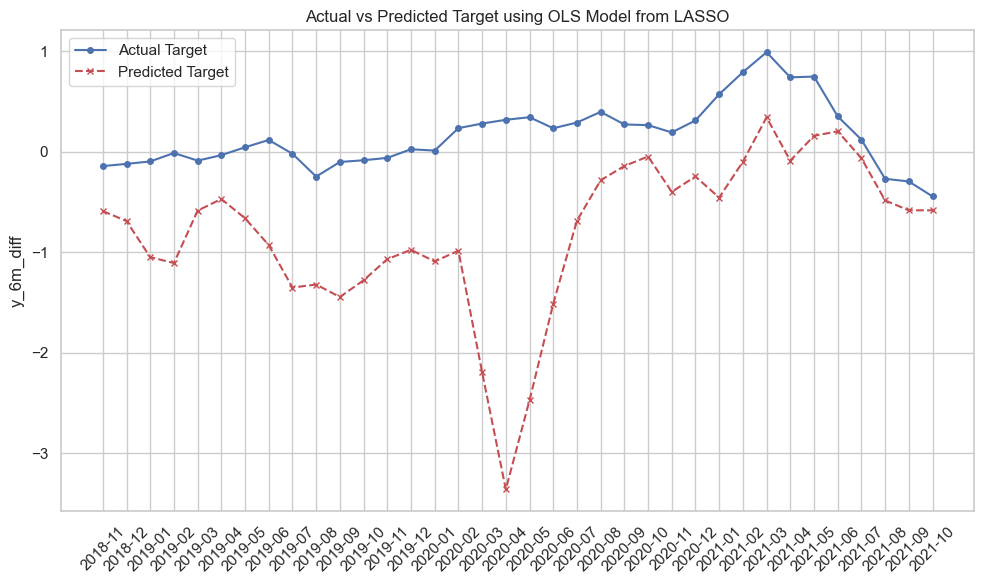

In [504]:
# Plotting the true vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label="Actual Target", color='b', linestyle='-', marker='o', markersize=4)
plt.plot(y_test.index, y_test_pred_ols, label="Predicted Target", color='r', linestyle='--', marker='x', markersize=4)

plt.ylabel('y_6m_diff')
plt.title('Actual vs Predicted Target using OLS Model from LASSO')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()